# Energy-Efficient Deep Learning for Finance

### Setup

#### Hyperparameters

In [1]:
# experiment options
TIME_PROFILING = False
MEMORY_PROFILING = True

BASELINE = True
LOW_BIT_TRAINING = True
PROGRESSIVE_TRAINING = False
ACTIVE_LEARNING = False

# data params
SERIES_INTERVAL = '1d'
LOOKBACK_WINDOW = 10
TRAIN_TEST_SPLIT = TRAIN_VAL_SPLIT = 0.8

# general model params 
EPOCHS = 10
BATCH_SIZE = 32
NODES_PER_LAYER = 24

# low-bit training
MIXED_PRECISION = 'mixed_float16'
HIGH_PRECISION = 'float32'

# progressive training params
PRETRAINING_EPOCHS = 20
TUNING_EPOCHS = 30

# active learning params: (100, 100, 2) is the best, (90, 90, 2) produces comparable RMSE at 56% data 
AL_ITERATIONS = 100
AL_SAMPLE = 100
AL_EPOCHS_PER_IT = 2

#### Imports

In [2]:
# if running through colab, install external packages
!pip3 install -r ./drive/MyDrive/UCL/Thesis/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from datetime import datetime
from time import time
from scipy.stats import norm

# financial imports
import yfinance as yf

# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.metrics import RootMeanSquaredError

# scikit-learn imports
from sklearn.utils import shuffle
from sklearn.metrics import r2_score

# profiling imports
from line_profiler import LineProfiler
from memory_profiler import memory_usage

In [4]:
# check if connected to a GPU
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-4fdad29a-8c05-2bf5-aa11-0868b92d8fd7)


#### Output Directory

In [5]:
# construct path to directory in which plots and profiling metrics are saved
results_path = './drive/MyDrive/UCL/Thesis/results/'

if not os.path.isdir(results_path):
    now = datetime.now()
    now = now.strftime("%d-%m-%Y_%H-%M-%S")
    results_path = f'./results_{now}/'
    os.mkdir(results_path)

print(f"Results will be saved to the directory: {results_path}")

Results will be saved to the directory: ./drive/MyDrive/UCL/Thesis/results/


### Data Curation and Manipulation

In [6]:
# formula for historical volatility
def compute_volatility(window):
    _v = window - np.mean(window)
    _v = np.square(_v)
    _v = np.sum(_v)
    _v = _v / LOOKBACK_WINDOW
    _v = np.sqrt(_v)

    return _v

#### Creating Multivariate Time Series

In [7]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(start='1950-01-04', end='2022-08-02', interval=SERIES_INTERVAL)

close = sp500_history.Close.loc[sp500_history.Close != 0]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = [compute_volatility(log_returns[i: i + LOOKBACK_WINDOW]) for i in range(log_returns.shape[0] - LOOKBACK_WINDOW)]

# gather other variables
_open = sp500_history.Open[1:]
_high = sp500_history.High[1:]
_low = sp500_history.Low[1:]
_volume = sp500_history.Volume[1:]

close = close[1:]
volatility = pd.Series(volatility, index=log_returns[LOOKBACK_WINDOW:].keys())

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'open': (_open - _open.min()) / _open.max(),
    'close': (close - close.min()) / close.max(),
    'high': (_high - _high.min()) / _high.max(),
    'low': (_low - _low.min()) / _low.max(),
    'volume': (_volume - _volume.min()) / _volume.max(),

    'returns': log_returns / np.abs(log_returns).max(),  # already centred about 0
    'volatility': (volatility - volatility.min()) / volatility.max()
})

# fill nan values in volatility column (these won't be used)
X.volatility = X.volatility.fillna(0)

display(X)

,open,close,high,low,volume,returns,volatility
Date,,,,,,,
1950-01-05,0.003524,0.000054,0.000054,0.000054,0.000163,0.020684,0.000000
1950-01-06,0.003534,0.000065,0.000064,0.000065,0.000116,0.012878,0.000000
1950-01-09,0.003555,0.000085,0.000085,0.000086,0.000161,0.025642,0.000000
1950-01-10,0.003545,0.000075,0.000075,0.000075,0.000129,-0.012802,0.000000
1950-01-11,0.003557,0.000088,0.000087,0.000088,0.000170,0.015358,0.000000
...,...,...,...,...,...,...,...
2022-07-26,0.822814,0.813996,0.816945,0.814652,0.269089,-0.050701,0.126826
2022-07-27,0.822442,0.835378,0.834864,0.823165,0.312798,0.112753,0.129777
2022-07-28,0.837990,0.845556,0.843038,0.831855,0.338870,0.052666,0.147466


#### Visualising Price, Return, and Volatility Data

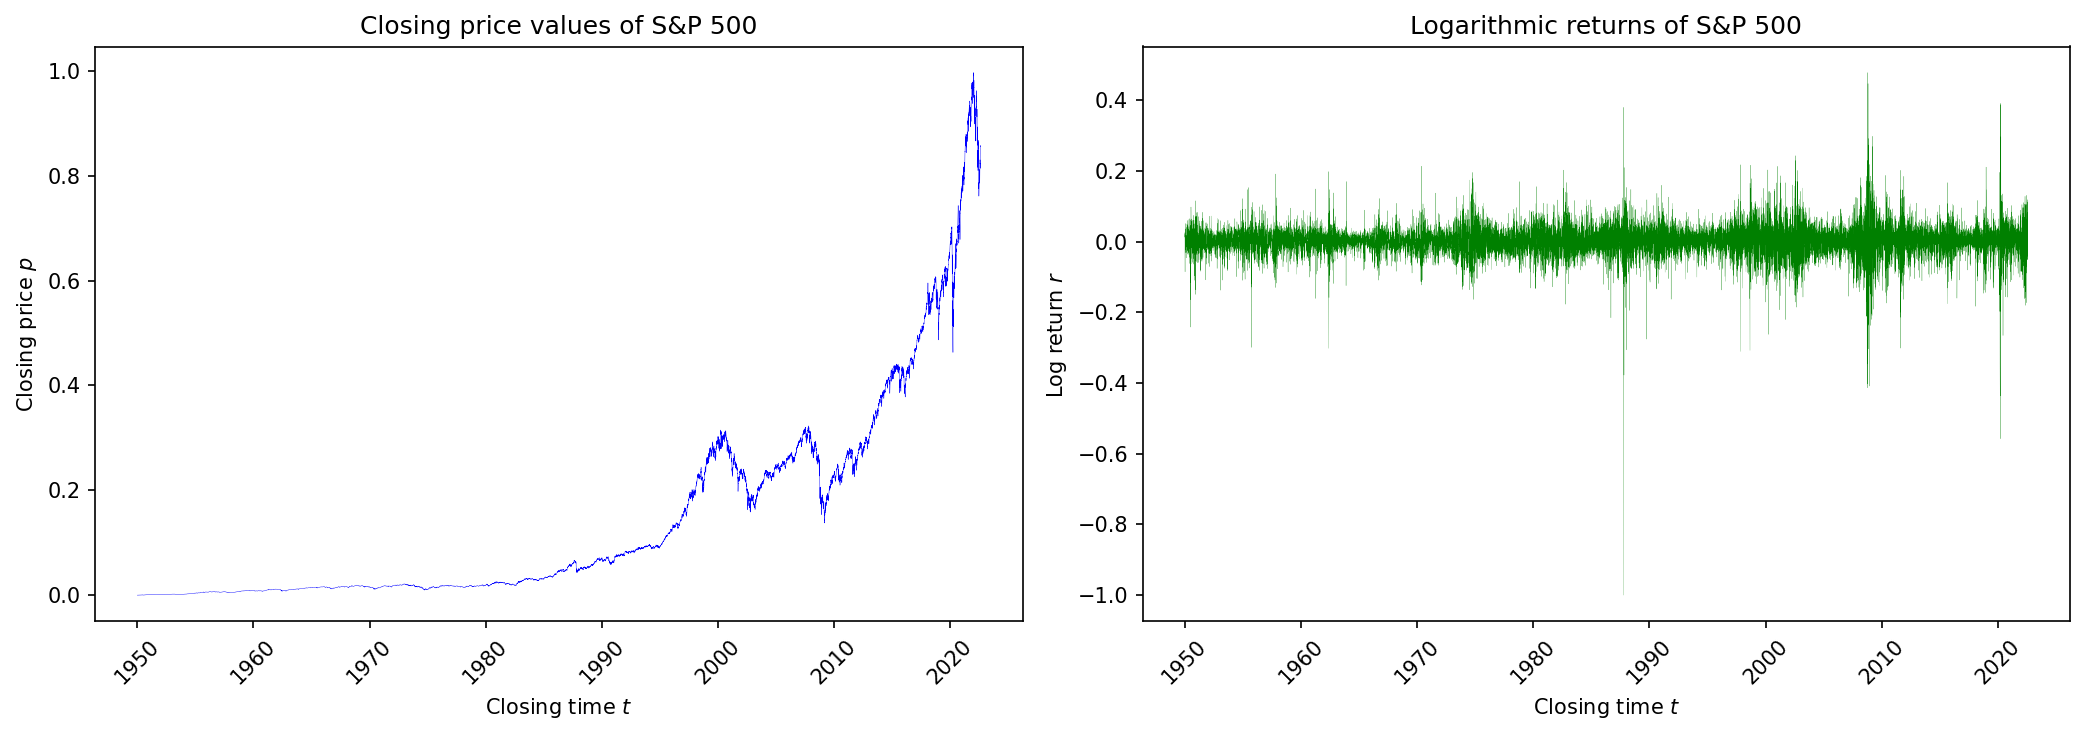

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

ax[0].plot(X.close, linewidth=0.2, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.1, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
fig.savefig(results_path + "dataset.png")

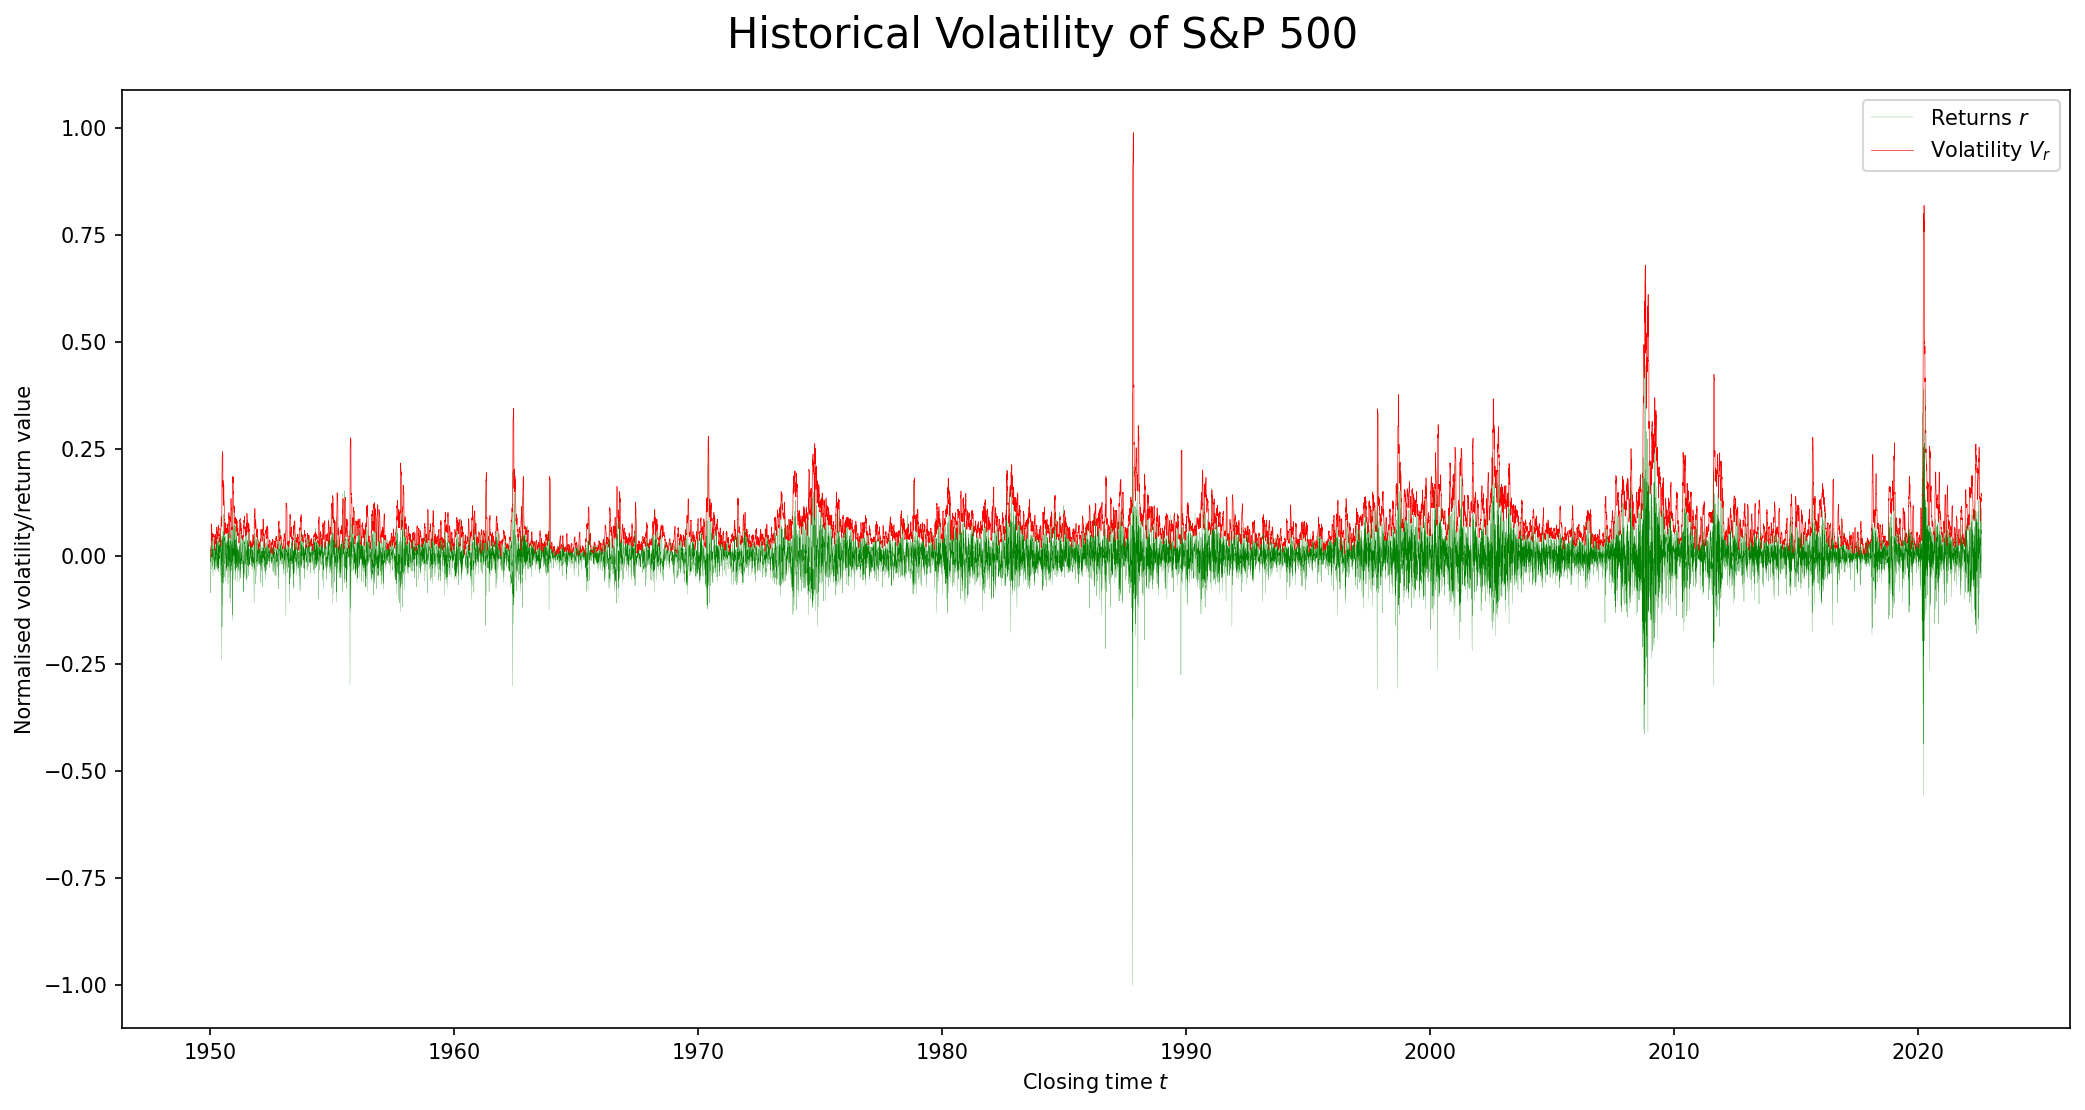

In [9]:
# plot computed volatility
fig, ax = plt.subplots(figsize=(14, 7), dpi=150)
fig.suptitle("Historical Volatility of S&P 500", y=1.05, fontsize=20)

ax.plot(X.returns, linewidth=0.1, color='g', label='Returns $r$')
ax.plot(X.volatility, linewidth=0.3, color='r', label='Volatility $V_r$')
ax.set(xlabel=r'Closing time $t$', ylabel='Normalised volatility/return value')
ax.legend()

plt.tight_layout()
plt.show()
fig.savefig(results_path + "volatility.png")

#### Time Windowing & Train-Test Split

In [10]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the volatility value that comes at the next timestep after this series
X_data, y_data = [], []

for i in range(X.shape[0] - LOOKBACK_WINDOW):
    # compute volatility 
    X_data.append(X.values[i: i + LOOKBACK_WINDOW])
    y_data.append(X.volatility[i + LOOKBACK_WINDOW: i + LOOKBACK_WINDOW + 1])

# convert X, y to numpy arrays (and scale volatility)
X_data = np.array(X_data)
y_data = np.array(y_data)

# split into training and testing data
split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

X_train = X_data[:split]
y_train = y_data[:split]
X_test = X_data[split:]
y_test = y_data[split:]
X_train, y_train = shuffle(X_train, y_train)

print(f"{TRAIN_TEST_SPLIT * 100:.0f}% training data, {(1 - TRAIN_TEST_SPLIT) * 100:.0f}% testing data")
print("Train:", X_train.shape, y_train.shape, '\nTest: ', X_test.shape, y_test.shape)

80% training data, 20% testing data
Train: (14600, 10, 7) (14600, 1) 
Test:  (3651, 10, 7) (3651, 1)


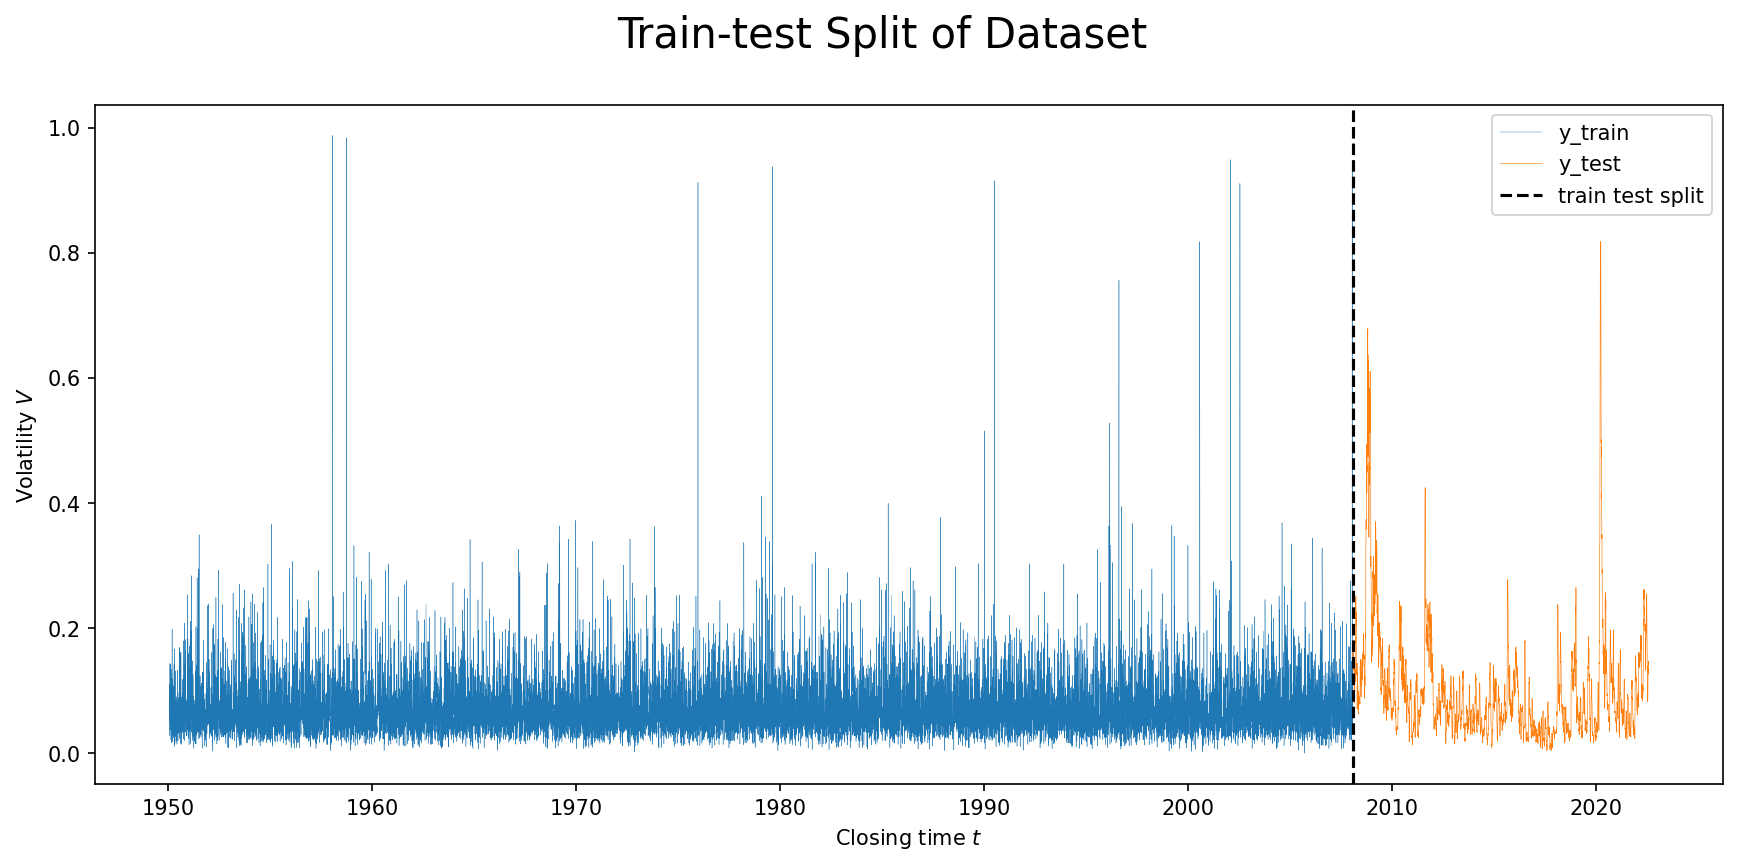

In [11]:
# plot the train-test split data
fig, ax = plt.subplots(figsize=(14, 6), dpi=150)
fig.suptitle("Train-test Split of Dataset", fontsize=20)

y_train_plot = y_train.flatten()
y_train_plot = pd.Series(y_train_plot, index=X.volatility[LOOKBACK_WINDOW: LOOKBACK_WINDOW + split].keys())

y_test_plot = y_test.flatten()
y_test_plot = pd.Series(y_test_plot, index=X.volatility[LOOKBACK_WINDOW + split:].keys())

ax.plot(y_train_plot, label='y_train', linewidth=0.2)
ax.plot(y_test_plot, label='y_test', linewidth=0.3)
ax.axvline(y_test_plot.keys()[0], color='k', linestyle='--', label='train test split')
ax.set(xlabel=r'Closing time $t$', ylabel=r'Volatility $V$')
ax.legend()

plt.show()
fig.savefig(results_path + "traintest-split.png")

#### Example Data Instance (a multivariate time series subsequence)

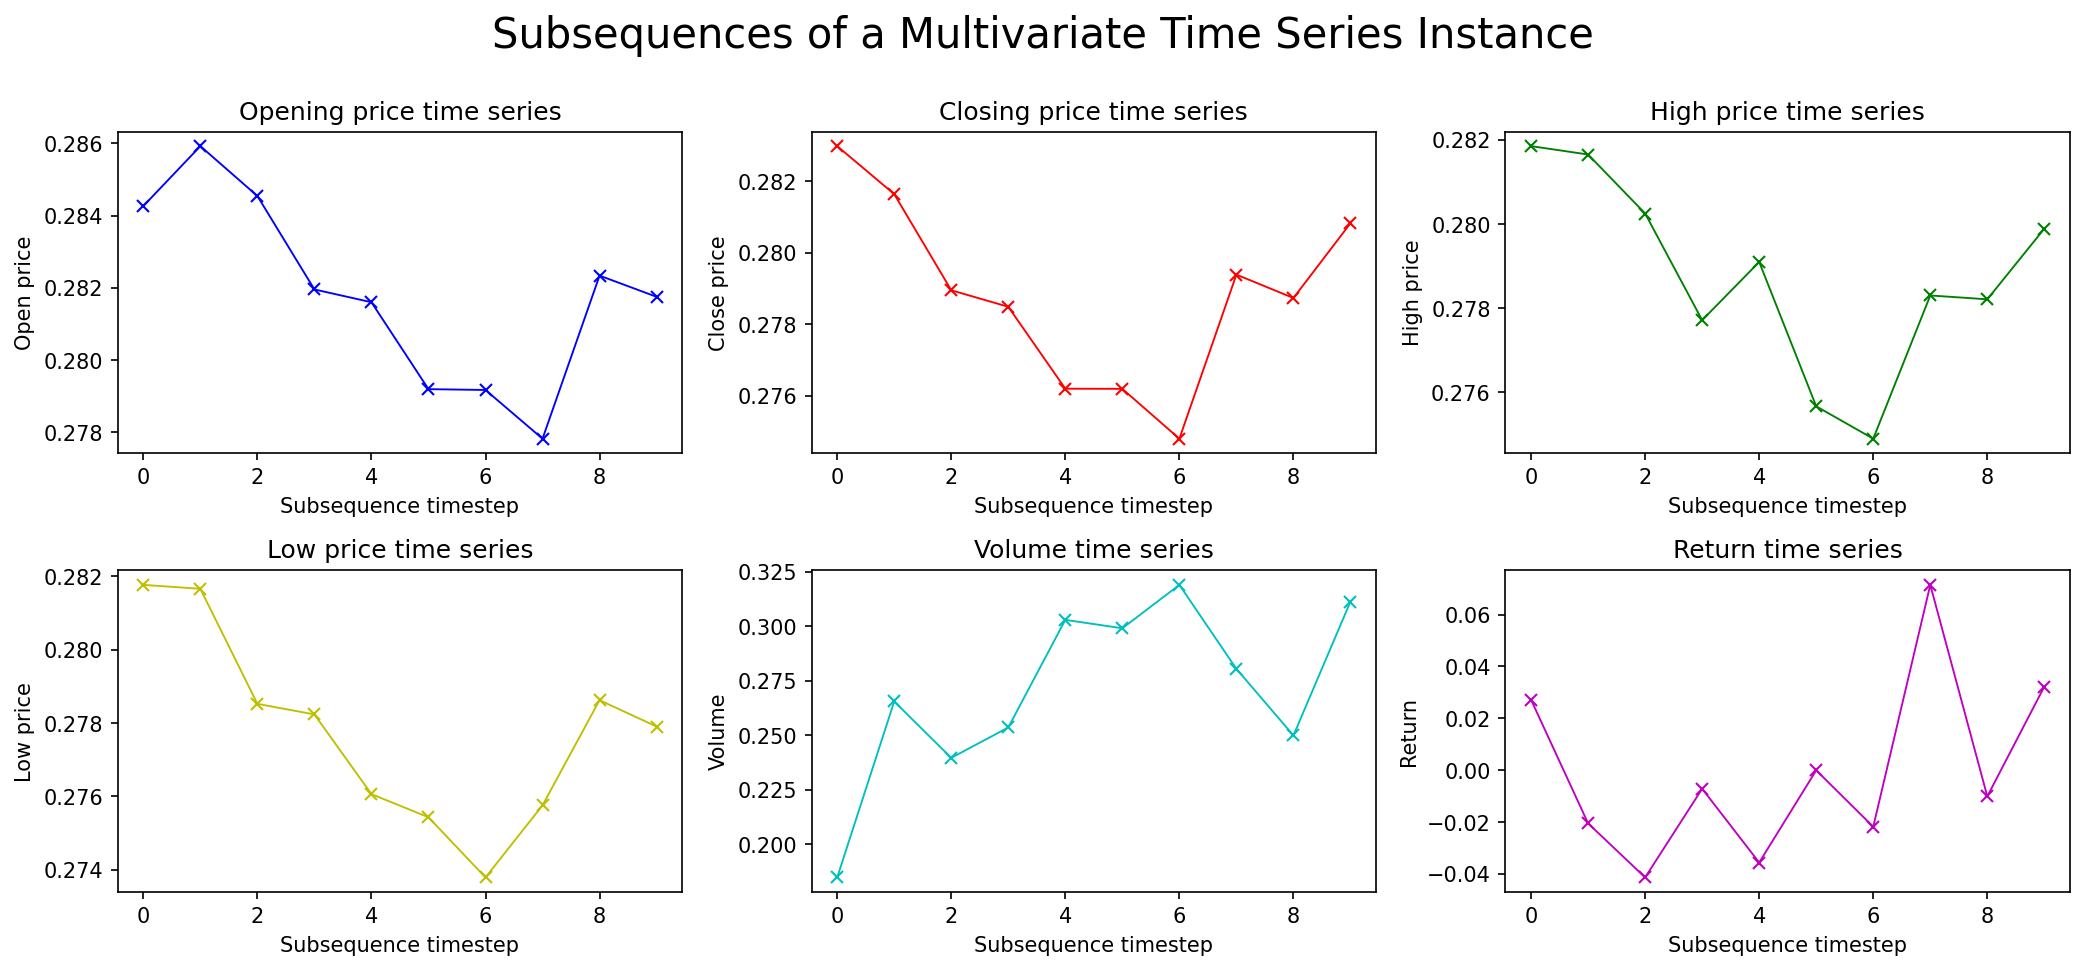

In [12]:
# examples of individual variable time series instance
np.random.seed(123)
random_index = np.random.randint(0, y_data.shape[0])
time_series = X_data[random_index]
label = y_data[random_index][0]

fig, ax = plt.subplots(2, 3, figsize=(14, 6), dpi=150)
fig.suptitle("Subsequences of a Multivariate Time Series Instance", y=1.07, fontsize=20)

ax[0, 0].plot(time_series[:, 0], color='b', marker='x', linewidth=0.9)
ax[0, 0].set(title=f'Opening price time series', xlabel=r'Subsequence timestep', ylabel=r'Open price')

ax[0, 1].plot(time_series[:, 1], color='r', marker='x', linewidth=0.9)
ax[0, 1].set(title=f'Closing price time series', xlabel=r'Subsequence timestep', ylabel=r'Close price')

ax[0, 2].plot(time_series[:, 2], color='g', marker='x', linewidth=0.9)
ax[0, 2].set(title=f'High price time series', xlabel=r'Subsequence timestep', ylabel=r'High price')

ax[1, 0].plot(time_series[:, 3], color='y', marker='x', linewidth=0.9)
ax[1, 0].set(title=f'Low price time series', xlabel=r'Subsequence timestep', ylabel=r'Low price')

ax[1, 1].plot(time_series[:, 4], color='c', marker='x', linewidth=0.9)
ax[1, 1].set(title=f'Volume time series', xlabel=r'Subsequence timestep', ylabel=r'Volume')

ax[1, 2].plot(time_series[:, 5], color='m', marker='x', linewidth=0.9)
ax[1, 2].set(title=f'Return time series', xlabel=r'Subsequence timestep', ylabel=r'Return')

plt.tight_layout()
plt.show()
fig.savefig(results_path + "subsequences.png")

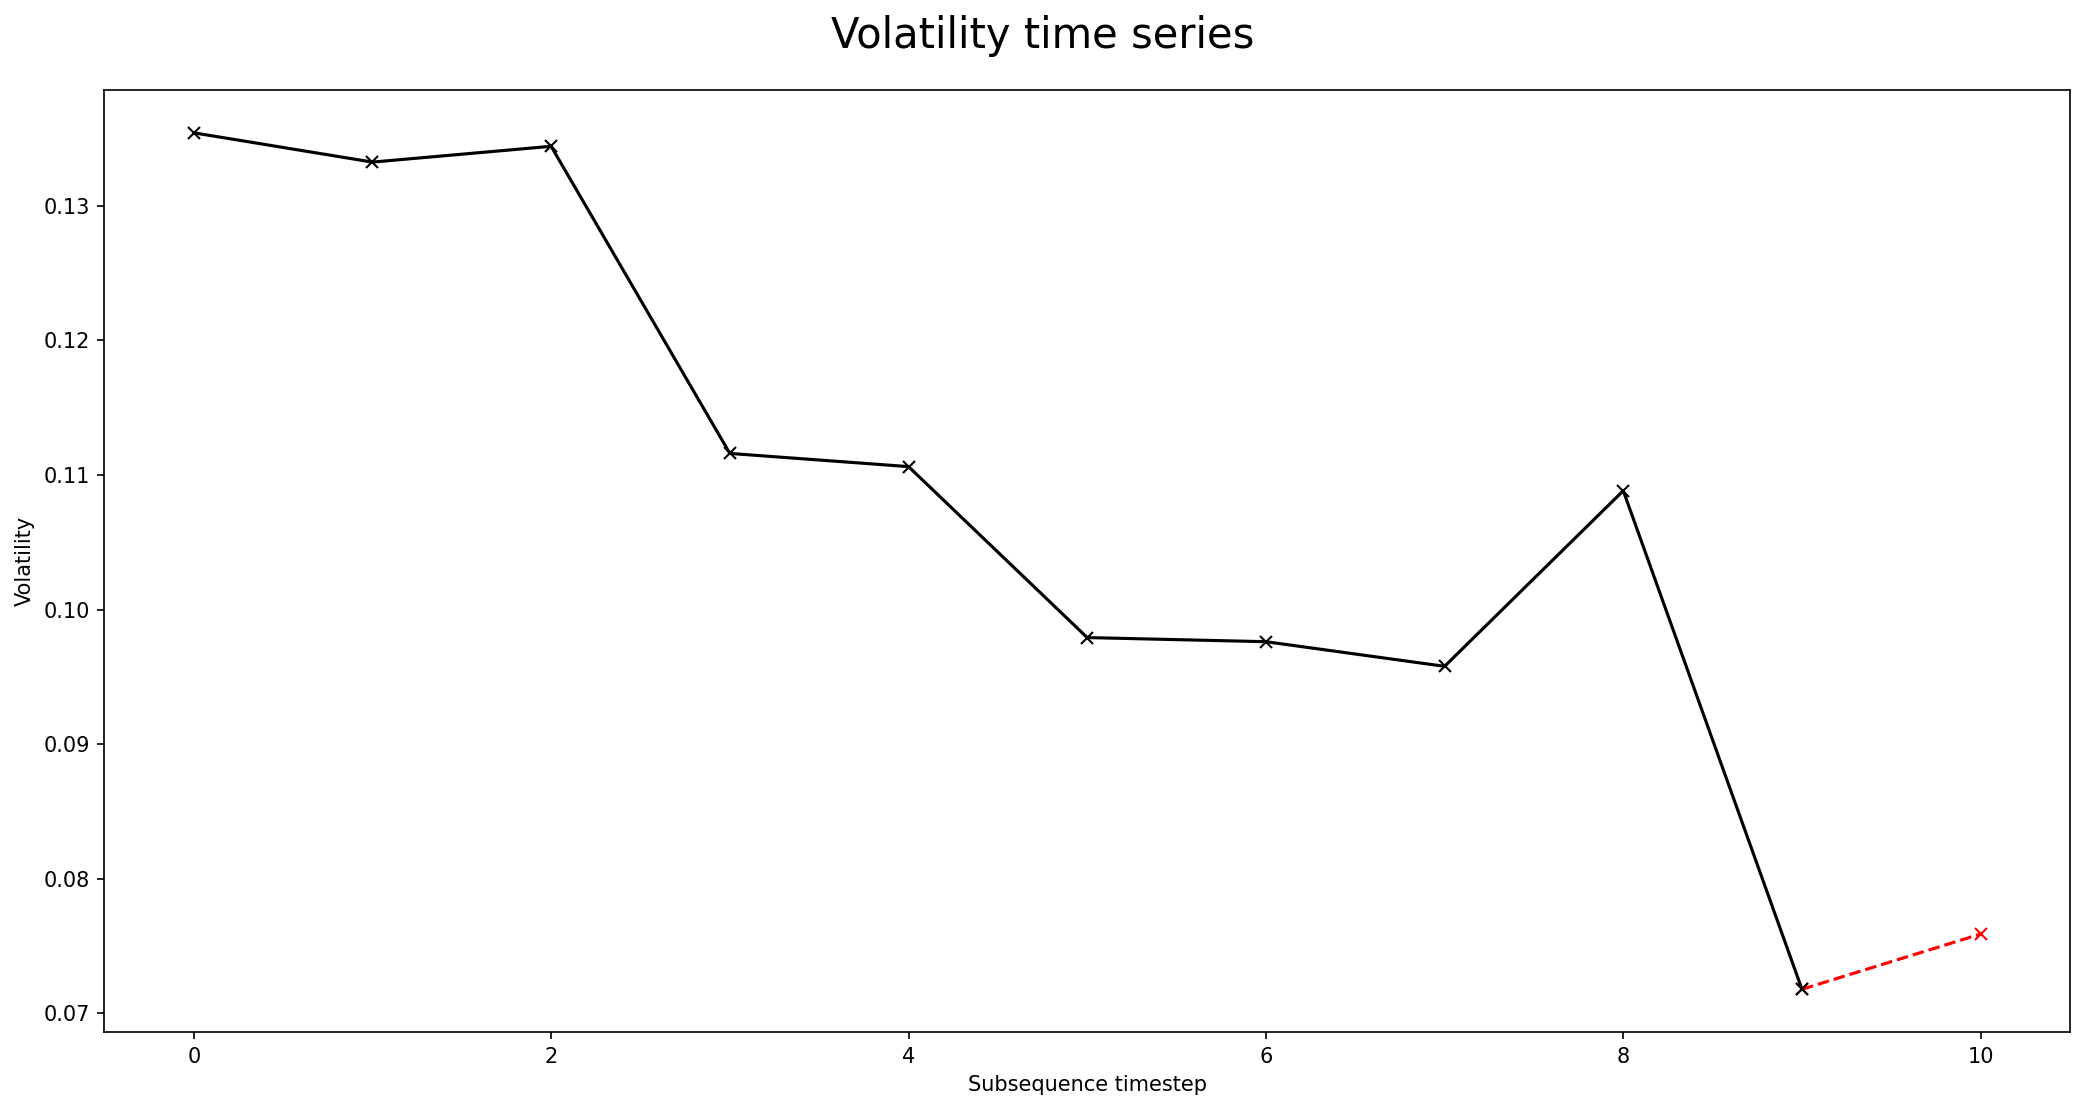

In [13]:
# example of volatility time series instance
fig, ax = plt.subplots(figsize=(14, 7), dpi=150)
fig.suptitle("Volatility time series", y=1.05, fontsize=20)

ax.plot([9, 10], [time_series[:, 6][-1], label], color='r', marker='x', linestyle='dashed')
ax.plot(time_series[:, 6], color='k', marker='x')
ax.set(xlabel=r'Subsequence timestep', ylabel=r'Volatility')

plt.tight_layout()
plt.show()
fig.savefig(results_path + "volatility-subsequence.png")

### Analysis Metrics

In [14]:
# metric functions
def compute_mae(y_true, y_hat):
    _ae = np.abs(np.subtract(y_true, y_hat))
    _mae = _ae.mean()

    return _mae


def compute_rmse(y_true, y_hat):
    _se = np.square(np.subtract(y_true, y_hat))
    _rmse = np.sqrt(_se.mean())

    return _rmse


def compute_mape(y_true, y_hat):
    _ape = np.abs((y_true - y_hat) / y_true)
    _mape = _ape.mean() * 100

    return _mape


# dictionary to store models and analyses
analysis = {
    'baseline': {
        'model': None,
        'history': None
    },
    'mixed-precision': {
        'model': None,
        'history': None
    },
    'sup-progressive': {
        'model': None,
        'history': None,
        'history_pre-training': None
    },
    'unsup-progressive': {
        'model': None,
        'history': None,
        'history_pre-training': None
    },
    'active-learning': {
        'model': None,
        'history': None,
        'pool-size': 0,
        'val-size': 0
    },
}

# dictionary to keep track of the test predictions of different models
predictions = {
    'true': pd.Series(y_test.flatten(), index=X.returns[split + LOOKBACK_WINDOW:].keys())
}

# dictionary to keep track of the test accuracy metrics
accuracy = {}

### Baseline Volatility Forecasting Model

#### Setting Precision

In [15]:
# ensure tensorflow is using high precision (i.e. not in low-bit training mode)
policy_hp = mixed_precision.Policy(HIGH_PRECISION)
mixed_precision.set_global_policy(policy_hp)

print(f'Compute dtype: {policy_hp.compute_dtype}')
print(f'Variable dtype: {policy_hp.variable_dtype}')

Compute dtype: float32
Variable dtype: float32


#### Model Construction & Training Algorithms

In [16]:
# constructing the LSTM model architecture
def build_model(inputs):
     # build baseline model architecture
    model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, input_shape=(inputs.shape[1:]), activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'),
        Dense(1, activation='linear')
    ])

    # compile baseline model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=[RootMeanSquaredError()])

    return model


# baseline training algorithm
def train_model(model, inputs, labels, tag, save=True):
    # train model
    hist = model.fit(inputs, labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

    # save model and training history
    if save:
        analysis[tag]['model'] = model
        analysis[tag]['history'] = hist.history

#### Building Model

In [17]:
if BASELINE:
    # construct baseline model and show its architecture
    comp_model = build_model(X_train)
    comp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 24)            3072      
                                                                 
 lstm_1 (LSTM)               (None, 10, 24)            4704      
                                                                 
 lstm_2 (LSTM)               (None, 24)                4704      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 12,505
Trainable params: 12,505
Non-trainable params: 0
_________________________________________________________________


#### Training Model

In [18]:
if BASELINE:
    # train baseline model
    if TIME_PROFILING:
        # running line-by-line profiling over baseline training process
        baseline_profiler = LineProfiler()
        profile_function = baseline_profiler(train_model)
        profile_function(comp_model, X_train, y_train, 'baseline')

    if MEMORY_PROFILING:
        # create new model so training process starts from scratch
        comp_model_2 = build_model(X_train)

        # memory profiling of baseline training process
        save_history = not TIME_PROFILING
        baseline_memory = memory_usage((train_model, (comp_model_2, X_train, y_train, 'baseline', save_history)), interval=0.1, include_children=True)
    
    if not TIME_PROFILING and not MEMORY_PROFILING:
        # training
        train_model(comp_model, X_train, y_train, 'baseline')

Epoch 1/10
92/92 [==============================] - 7s 30ms/step - loss: 0.0264 - root_mean_squared_error: 0.0416 - val_loss: 0.0196 - val_root_mean_squared_error: 0.0324
Epoch 2/10
92/92 [==============================] - 2s 18ms/step - loss: 0.0195 - root_mean_squared_error: 0.0296 - val_loss: 0.0185 - val_root_mean_squared_error: 0.0308
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.0180 - root_mean_squared_error: 0.0268 - val_loss: 0.0169 - val_root_mean_squared_error: 0.0281
Epoch 4/10
92/92 [==============================] - 2s 17ms/step - loss: 0.0160 - root_mean_squared_error: 0.0237 - val_loss: 0.0142 - val_root_mean_squared_error: 0.0236
Epoch 5/10
92/92 [==============================] - 2s 17ms/step - loss: 0.0140 - root_mean_squared_error: 0.0209 - val_loss: 0.0136 - val_root_mean_squared_error: 0.0219
Epoch 6/10
92/92 [==============================] - 2s 17ms/step - loss: 0.0130 - root_mean_squared_error: 0.0200 - val_loss: 0.0126 - val_root_m

#### Evaluating Performance & Efficiency

In [19]:
if BASELINE and TIME_PROFILING:
    print("Profiling the baseline model's training process (Time in microseconds):", end='\n\n')
    baseline_profiler.print_stats()

Total memory consumption of baseline training process = 2899.29 MB


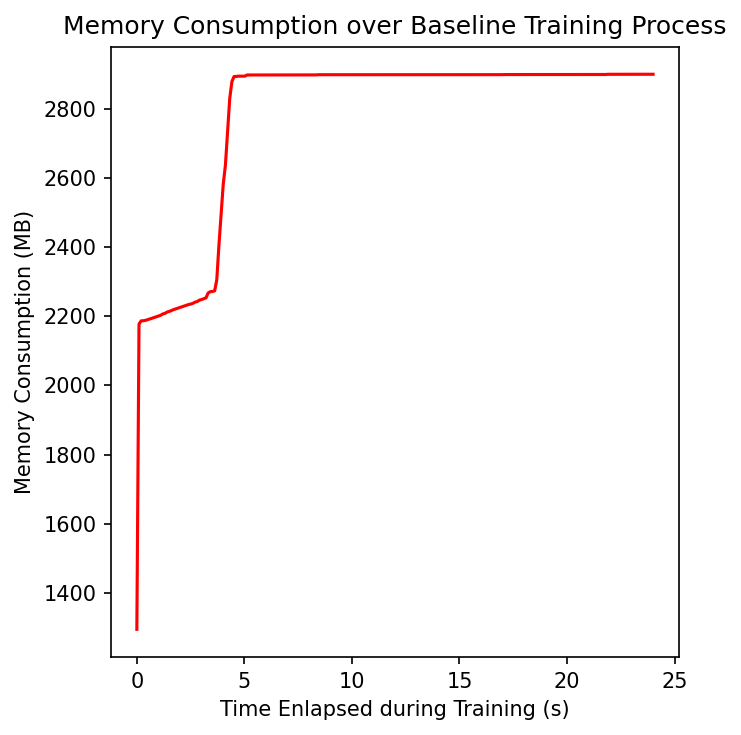

In [20]:
if BASELINE and MEMORY_PROFILING:
    # plot memory usage over the training process
    print(f"Total memory consumption of baseline training process = {baseline_memory[-1]:.2f} MB")
    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

    x_axis_values = np.linspace(0, 0.1 * len(baseline_memory), len(baseline_memory))
    ax.plot(x_axis_values, baseline_memory, color='r', label="Training")
    ax.set_xlabel('Time Enlapsed during Training (s)')
    ax.set_ylabel('Memory Consumption (MB)')
    ax.set_title('Memory Consumption over Baseline Training Process')

    plt.tight_layout()
    plt.show()

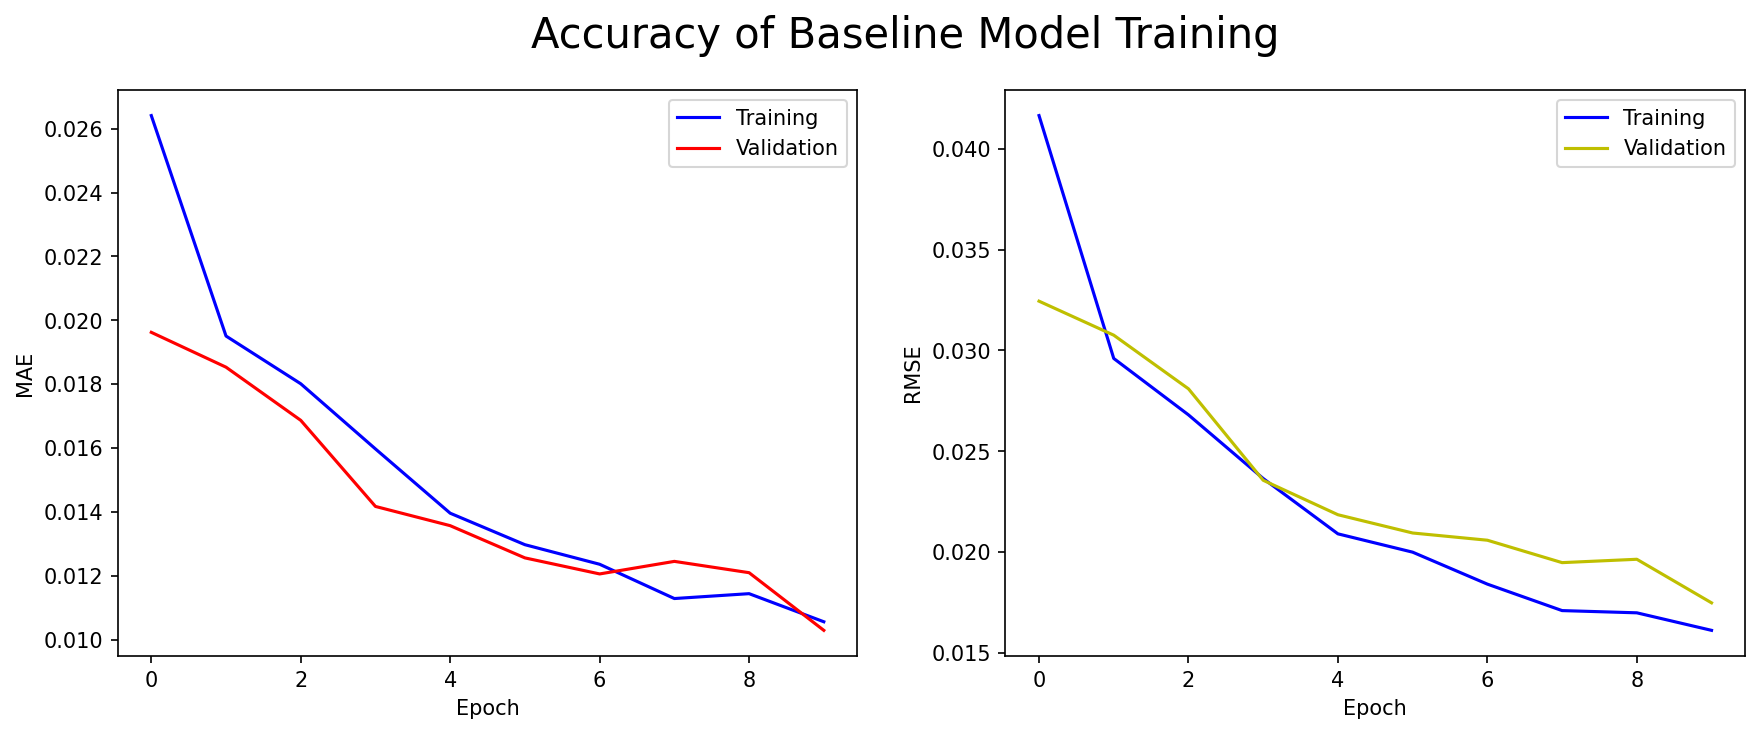

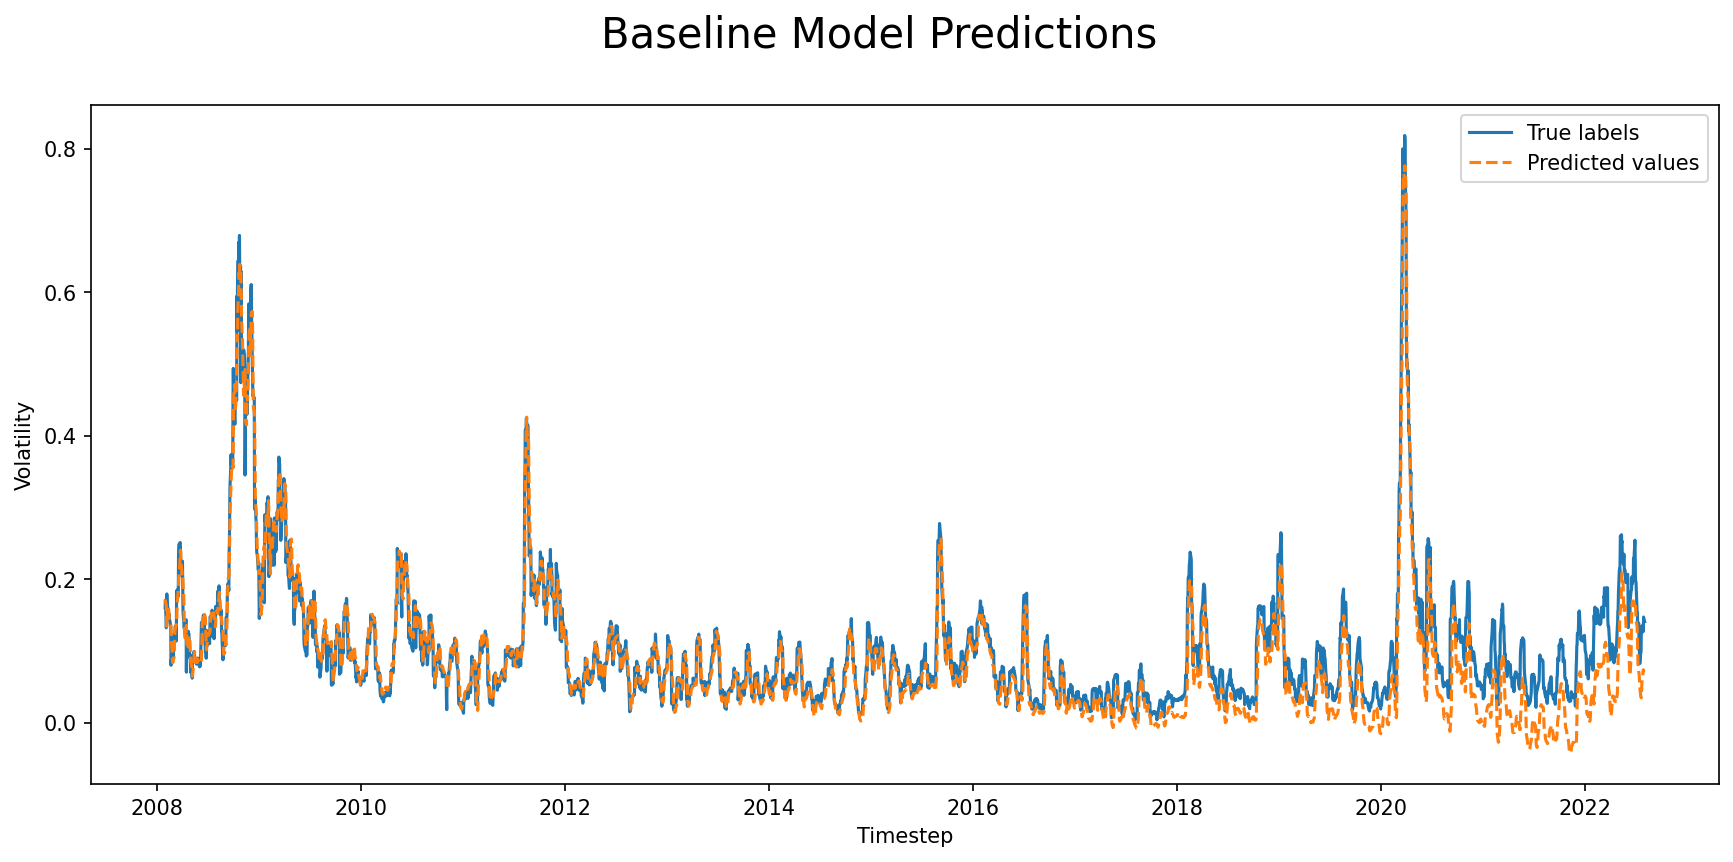

In [21]:
if BASELINE:
    # training loss plots    
    fig1, ax1 = plt.subplots(1, 2, figsize=(14, 5), dpi=150)
    fig1.suptitle("Accuracy of Baseline Model Training", fontsize=20)

    history_comp = analysis['baseline']['history']
    ax1[0].plot(history_comp['loss'], color='b', label="Training")
    ax1[0].plot(history_comp['val_loss'], color='r', label="Validation")
    ax1[0].legend(loc=0)
    ax1[0].set_xlabel('Epoch')
    ax1[0].set_ylabel('MAE')

    ax1[1].plot(history_comp['root_mean_squared_error'], color='b', label="Training")
    ax1[1].plot(history_comp['val_root_mean_squared_error'], color='y', label="Validation")
    ax1[1].legend(loc=0)
    ax1[1].set_xlabel('Epoch')
    ax1[1].set_ylabel('RMSE')

    # prediction plot
    if MEMORY_PROFILING and not TIME_PROFILING:
        y_pred_comp = comp_model_2.predict(X_test)
    else:
        y_pred_comp = comp_model.predict(X_test)
    
    y_pred_comp = y_pred_comp.flatten()
    y_pred_comp = pd.Series(y_pred_comp, index=X.returns[split + LOOKBACK_WINDOW:].keys())
    predictions['baseline'] = y_pred_comp

    fig2, ax2 = plt.subplots(figsize=(14, 6), dpi=150)
    fig2.suptitle("Baseline Model Predictions", fontsize=20)
    
    ax2.plot(predictions['true'], label='True labels')
    ax2.plot(y_pred_comp, linestyle='--', label='Predicted values')
    ax2.legend(loc=0)
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Volatility')
    
    plt.show()
    fig1.savefig(results_path + "loss-baseline.png")
    fig2.savefig(results_path + "predictions-baseline.png")

In [22]:
if BASELINE:
    # accuracy metrics
    mae = compute_mae(y_test.flatten(), y_pred_comp)
    rmse = compute_rmse(y_test.flatten(), y_pred_comp)
    mape = compute_mape(y_test.flatten(), y_pred_comp)
    r_squared = r2_score(y_test.flatten(), y_pred_comp)
    accuracy['baseline'] = {
        'r-squared': r_squared,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

    print("Accuracy metrics for baseline model:")
    print(f"* r^2 = {r_squared:.5f}")
    print(f"* mae = {mae:.5f}")
    print(f"* rmse = {rmse:.5f}")
    print(f"* mape = {mape:.5f}%")

Accuracy metrics for baseline model:
* r^2 = 0.87104
* mae = 0.02357
* rmse = 0.03305
* mape = 33.51536%


### Mixed-Precision Training

#### Setting Precision

In [23]:
if LOW_BIT_TRAINING:
    # set tensorflow to use mixed precision
    policy_mp = mixed_precision.Policy(MIXED_PRECISION)
    mixed_precision.set_global_policy(policy_mp)

    print(f'Compute dtype: {policy_mp.compute_dtype}')
    print(f'Variable dtype: {policy_mp.variable_dtype}')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Compute dtype: float16
Variable dtype: float32


#### Building Model

In [24]:
if LOW_BIT_TRAINING:
    # mixed-precision training uses the same architecture as the baseline
    mp_model = build_model(X_train)
    mp_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 24)            3072      
                                                                 
 lstm_7 (LSTM)               (None, 10, 24)            4704      
                                                                 
 lstm_8 (LSTM)               (None, 24)                4704      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 12,505
Trainable params: 12,505
Non-trainable params: 0
_________________________________________________________________


#### Training Model

In [25]:
if LOW_BIT_TRAINING:
    # conduct mixed-precision training using baseline training algorithm but evaluated at lower precision
    if TIME_PROFILING:
        # running line-by-line profiling over mixed-precision training process
        mp_profiler = LineProfiler()
        profile_function = mp_profiler(train_model)
        profile_function(mp_model, X_train, y_train, 'mixed-precision')

    if MEMORY_PROFILING:
        # memory profiling of nixed-precision training process
        mp_model_2 = build_model(X_train)
        save_history = not TIME_PROFILING
        mp_memory = memory_usage((train_model, (mp_model_2, X_train, y_train, 'mixed-precision', save_history)), interval=0.1, include_children=True)
    
    if not TIME_PROFILING and not MEMORY_PROFILING:
        # training
        train_model(mp_model, X_train, y_train, 'mixed-precision')

Epoch 1/10
92/92 [==============================] - 8s 32ms/step - loss: 0.0262 - root_mean_squared_error: 0.0411 - val_loss: 0.0215 - val_root_mean_squared_error: 0.0354
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 0.0200 - root_mean_squared_error: 0.0300 - val_loss: 0.0204 - val_root_mean_squared_error: 0.0336
Epoch 3/10
92/92 [==============================] - 2s 21ms/step - loss: 0.0184 - root_mean_squared_error: 0.0273 - val_loss: 0.0179 - val_root_mean_squared_error: 0.0307
Epoch 4/10
92/92 [==============================] - 2s 21ms/step - loss: 0.0176 - root_mean_squared_error: 0.0260 - val_loss: 0.0168 - val_root_mean_squared_error: 0.0289
Epoch 5/10
92/92 [==============================] - 2s 21ms/step - loss: 0.0159 - root_mean_squared_error: 0.0234 - val_loss: 0.0163 - val_root_mean_squared_error: 0.0250
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.0141 - root_mean_squared_error: 0.0204 - val_loss: 0.0129 - val_root_m

#### Evaluating Performance & Efficiency

In [26]:
if BASELINE and TIME_PROFILING:
    print("Profiling the mixed-precision training process (Time in microseconds):", end='\n\n')
    mp_profiler.print_stats()

Total memory consumption of baseline training process = 3549.32 MB


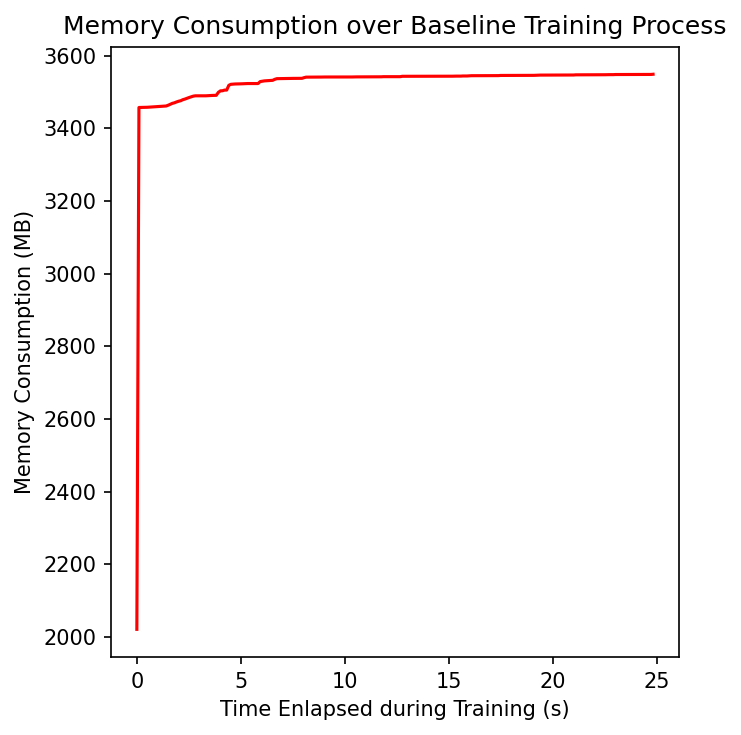

In [27]:
if BASELINE and MEMORY_PROFILING:
    # plot memory usage over the training process
    print(f"Total memory consumption of baseline training process = {mp_memory[-1]:.2f} MB")
    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

    x_axis_values = np.linspace(0, 0.1 * len(mp_memory), len(mp_memory))
    ax.plot(x_axis_values, mp_memory, color='r', label="Training")
    ax.set_xlabel('Time Enlapsed during Training (s)')
    ax.set_ylabel('Memory Consumption (MB)')
    ax.set_title('Memory Consumption over Baseline Training Process')

    plt.tight_layout()
    plt.show()

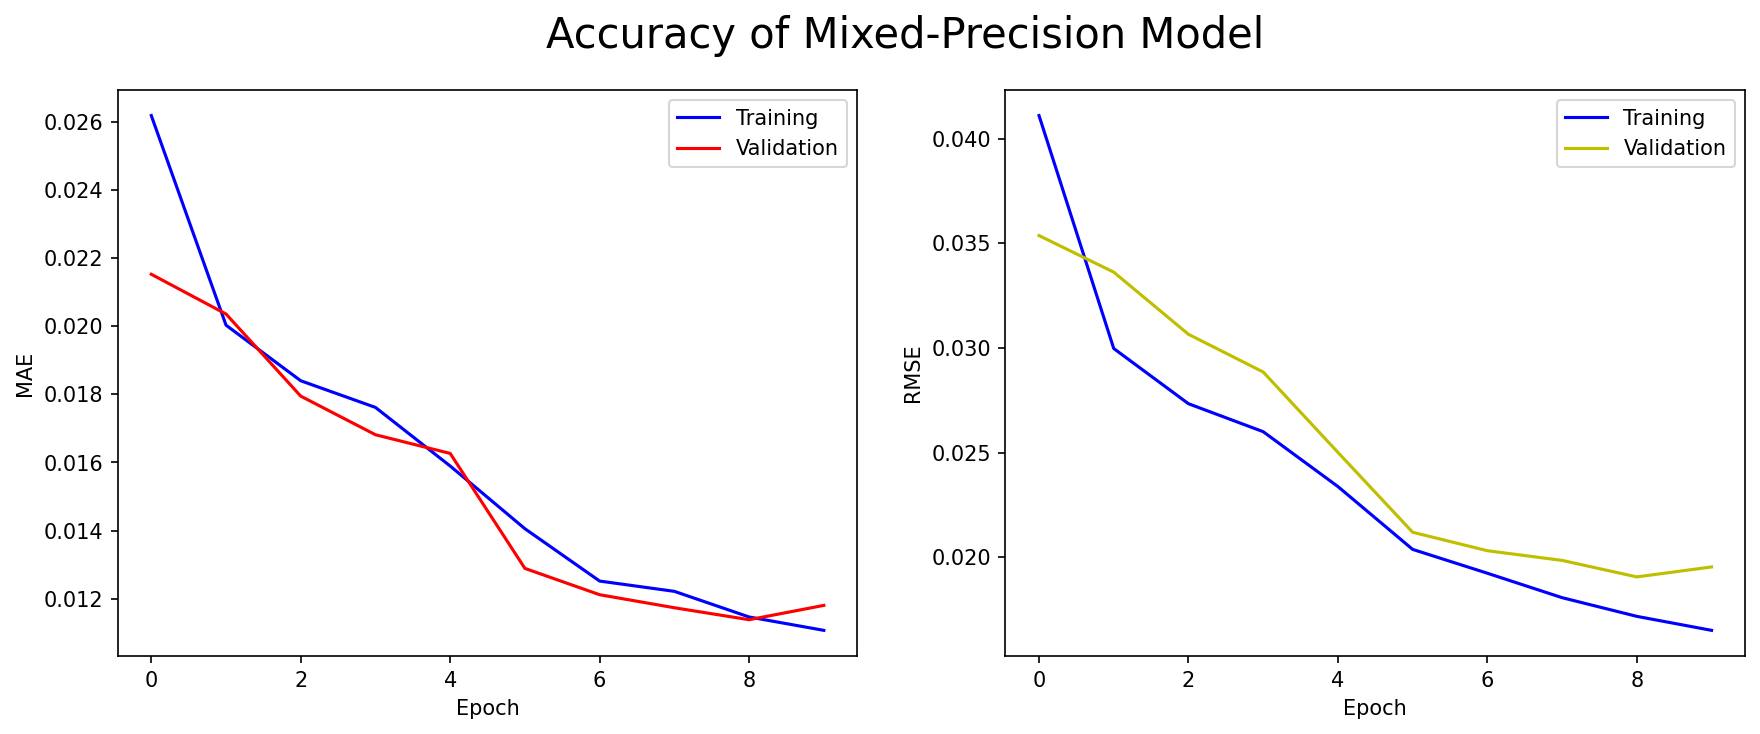

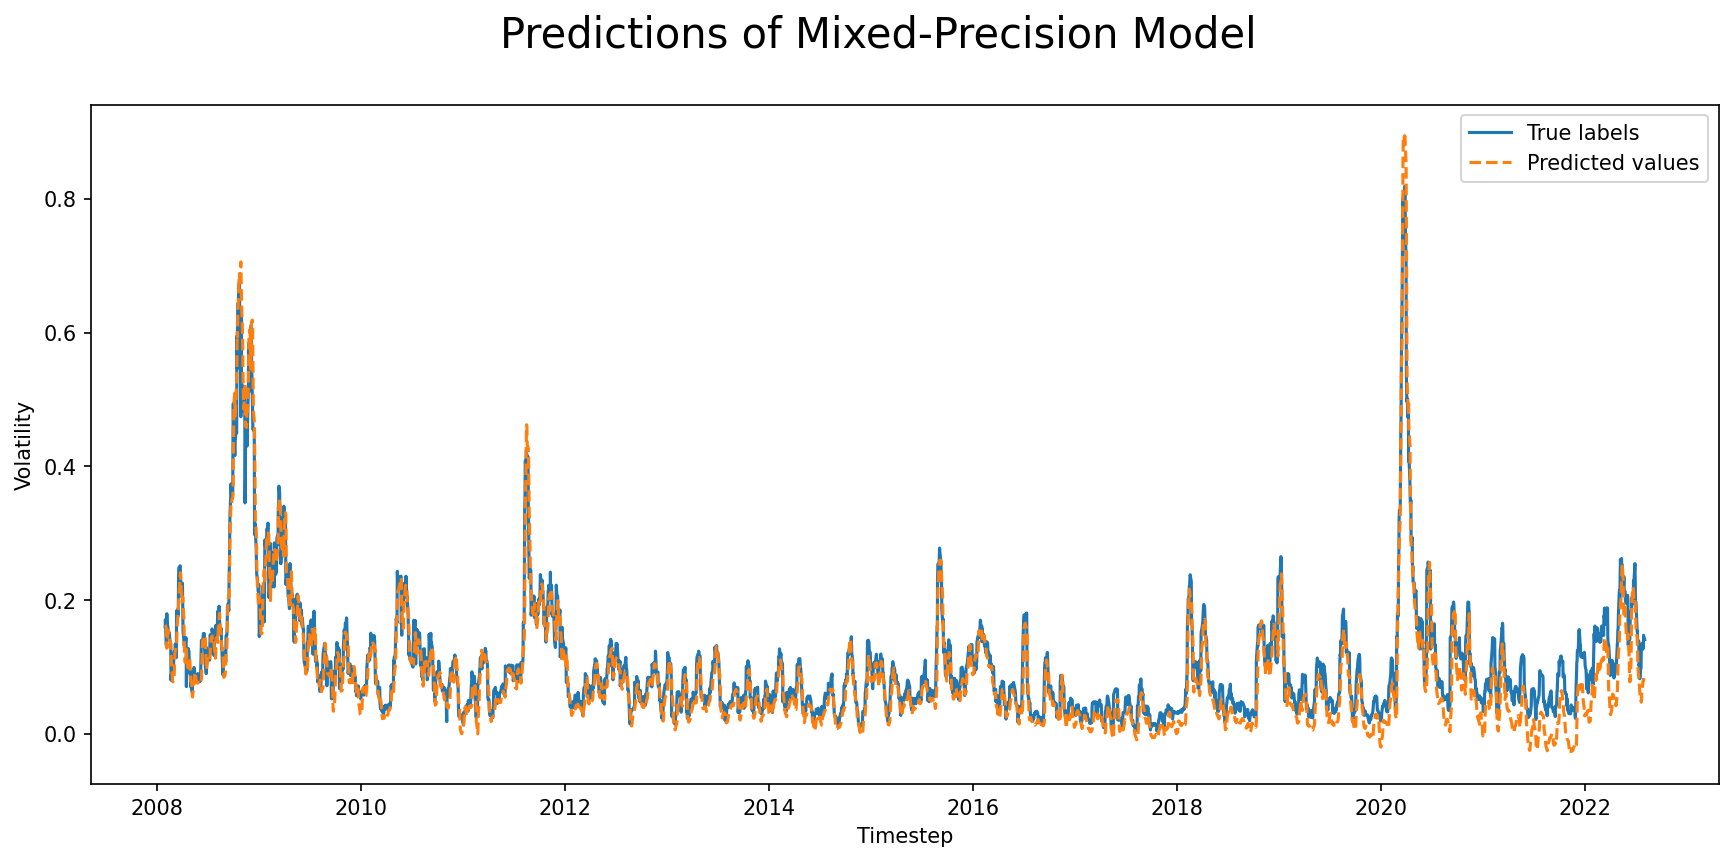

In [28]:
if LOW_BIT_TRAINING:
    # training loss plots
    fig1, ax1 = plt.subplots(1, 2, figsize=(14, 5), dpi=150)
    fig1.suptitle("Accuracy of Mixed-Precision Model", fontsize=20)

    history_mp = analysis['mixed-precision']['history']
    ax1[0].plot(history_mp['loss'], color='b', label="Training")
    ax1[0].plot(history_mp['val_loss'], color='r', label="Validation")
    ax1[0].legend(loc=0)
    ax1[0].set_xlabel('Epoch')
    ax1[0].set_ylabel('MAE')

    ax1[1].plot(history_mp['root_mean_squared_error'], color='b', label="Training")
    ax1[1].plot(history_mp['val_root_mean_squared_error'], color='y', label="Validation")
    ax1[1].legend(loc=0)
    ax1[1].set_xlabel('Epoch')
    ax1[1].set_ylabel('RMSE')

    # prediction plot
    if MEMORY_PROFILING and not TIME_PROFILING:
        y_pred_mp = mp_model_2.predict(X_test)
    else:
        y_pred_mp = mp_model.predict(X_test)
    
    y_pred_mp = y_pred_mp.flatten()
    y_pred_mp = pd.Series(y_pred_mp, index=X.returns[split + LOOKBACK_WINDOW:].keys())
    predictions['mixed-precision'] = y_pred_mp

    fig2, ax2 = plt.subplots(figsize=(14, 6), dpi=150)
    fig2.suptitle("Predictions of Mixed-Precision Model", fontsize=20)

    ax2.plot(predictions['true'], label='True labels')
    ax2.plot(y_pred_mp, linestyle='--', label='Predicted values')
    ax2.legend(loc=0)
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Volatility')

    plt.show()
    fig1.savefig(results_path + "loss-mixedprecision.png")
    fig2.savefig(results_path + "predictions-mixedprecision.png")

In [29]:
if LOW_BIT_TRAINING:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_mp)
    rmse = compute_rmse(y_test.flatten(), y_pred_mp)
    mape = compute_mape(y_test.flatten(), y_pred_mp)
    r_squared = r2_score(y_test.flatten(), y_pred_mp)
    accuracy['mixed-precision'] = {
        'r-squared': r_squared,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

    print("Accuracy metrics for mixed-precision model:")
    print(f"* r^2 = {r_squared:.5f}")
    print(f"* mae = {mae:.5f}")
    print(f"* rmse = {rmse:.5f}")
    print(f"* mape = {mape:.5f}%")

Accuracy metrics for mixed-precision model:
* r^2 = 0.89577
* mae = 0.02190
* rmse = 0.02971
* mape = 30.66968%


### Supervised Layer-wise Pre-Training

#### Setting Precision

In [30]:
if PROGRESSIVE_TRAINING:
    # ensure tensorflow is using high precision (i.e. not in low-bit training mode)
    policy_hp = mixed_precision.Policy(HIGH_PRECISION)
    mixed_precision.set_global_policy(policy_hp)

    print(f'Compute dtype: {policy_hp.compute_dtype}')
    print(f'Variable dtype: {policy_hp.variable_dtype}')

#### Model Construction & Training Algorithms

In [31]:
# train the initial model
def base_model(inputs, labels):
    # define base model
    model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh', input_shape=(inputs.shape[1:])),
        Dense(1, activation='linear')
    ])
    
    # compile and train base model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=[RootMeanSquaredError()])
    hist = model.fit(inputs, labels, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

    return model, hist.history


# add a layer to the model and train it
def progress_layers(model, inputs, labels, sup_history, ret_seq):
    # save then remove output layer
    output = model.layers[-1]
    model.pop()

    # halt training on existing layers
    for l in model.layers: l.trainable = False

    # add new layer and restore output layer (if final LSTM layer, do not return sequences)
    model.add(LSTM(NODES_PER_LAYER, return_sequences=ret_seq, activation='tanh'))
    model.add(output)

    # retrain newest layer (+ output layer)
    hist = model.fit(inputs, labels, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

    # metrics
    sup_history['loss'].extend(hist.history['loss'])
    sup_history['val_loss'].extend(hist.history['val_loss'])
    sup_history['root_mean_squared_error'].extend(hist.history['root_mean_squared_error'])
    sup_history['val_root_mean_squared_error'].extend(hist.history['val_root_mean_squared_error'])

    return model, sup_history


# final tuning over full model
def final_training_round(model, inputs, labels):
    # make all layers tunable again
    for l in model.layers: l.trainable = True

    # recompile with regression loss function
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=[RootMeanSquaredError()])

    # train regressor
    history = model.fit(inputs, labels, epochs=TUNING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    
    return model, history.history


# full pre-training algrotihm
def supervised_pretraining(inputs, labels):
    # initial model
    sup_model, history_sup_pretraining = base_model(inputs, labels)

    # add 2nd LSTM layer & pre-train
    sup_model, history_sup_pretraining = progress_layers(sup_model, inputs, labels, history_sup_pretraining, ret_seq=True)
    
    # add 3rd LSTM layer & pre-train
    sup_model, history_sup_pretraining = progress_layers(sup_model, inputs, labels, history_sup_pretraining, ret_seq=False)

    # save model and pre-training history
    analysis['sup-progressive']['model'] = sup_model
    analysis['sup-progressive']['history_pre-training'] = history_sup_pretraining


# full tuning algorithm
def supervised_tuning(inputs, labels):
    # tune the complete model
    sup_model = analysis['sup-progressive']['model']
    sup_model, history_sup_tuning = final_training_round(sup_model, inputs, labels)

    # save model and tuning history
    analysis['sup-progressive']['model'] = sup_model
    analysis['sup-progressive']['history'] = history_sup_tuning


#### Pre-Training & Tuning

In [32]:
if PROGRESSIVE_TRAINING:
    # train baseline model
    if TIME_PROFILING:
        # profiling of pre-training process
        sup_pre_profiler = LineProfiler()
        profile_function = sup_pre_profiler(supervised_pretraining)
        profile_function(X_train, y_train)

        # profiling of tuning process
        sup_tune_profiler = LineProfiler()
        profile_function = sup_tune_profiler(supervised_tuning)
        profile_function(X_train, y_train)
    else:
        # pre-training
        supervised_pretraining(X_train, y_train)

        # tuning
        supervised_tuning(X_train, y_train)

In [33]:
if PROGRESSIVE_TRAINING:
    # Supervised model architecture
    sup_model = analysis['sup-progressive']['model']
    sup_model.summary()

#### Evaluating Performance & Efficiency

In [34]:
if PROGRESSIVE_TRAINING and TIME_PROFILING:
    print("Profiling the supervised layer-wise pre-training process (Time in microseconds):")
    print("Pre-training:", end='\n\n')
    sup_pre_profiler.print_stats()

In [35]:
if PROGRESSIVE_TRAINING and TIME_PROFILING:
    print("Tuning:", end='\n\n')
    sup_tune_profiler.print_stats()

In [36]:
if PROGRESSIVE_TRAINING:
    # pretraining loss plots
    fig1, ax1 = plt.subplots(2, 2, figsize=(14, 12), dpi=150)
    fig1.suptitle("Accuracy of Pre-Training and Tuning", fontsize=20)

    history_sup_pretraining = analysis['sup-progressive']['history_pre-training']
    ax1[0, 0].plot(history_sup_pretraining['loss'], color='b', label="Training")
    ax1[0, 0].plot(history_sup_pretraining['val_loss'], color='r', label="Validation")
    ax1[0, 0].legend(loc=0)
    ax1[0, 0].set(title='MAE over Pre-Training', xlabel='Epochs', ylabel='MAE')

    ax1[0, 1].plot(history_sup_pretraining['root_mean_squared_error'], color='b', label="Training")
    ax1[0, 1].plot(history_sup_pretraining['val_root_mean_squared_error'], color='y', label="Validation)")
    ax1[0, 1].legend(loc=0)
    ax1[0, 1].set(title='RMSE over Pre-Training', xlabel='Epochs', ylabel='RMSE')

    # tuning loss plots
    history_sup_tuning = analysis['sup-progressive']['history']
    ax1[1, 0].plot(history_sup_tuning['loss'], color='b', label="Training")
    ax1[1, 0].plot(history_sup_tuning['val_loss'], color='r', label="Validation")
    ax1[1, 0].legend(loc=0)
    ax1[1, 0].set(title='MAE over Final Tuning', xlabel='Epoch', ylabel='MAE')

    ax1[1, 1].plot(history_sup_tuning['root_mean_squared_error'], color='b', label="Training")
    ax1[1, 1].plot(history_sup_tuning['val_root_mean_squared_error'], color='y', label="Validation")
    ax1[1, 1].legend(loc=0)
    ax1[1, 1].set(title='RMSE over Final Tuning', xlabel='Epoch', ylabel='RMSE')

    # prediction plot
    y_pred_sup = sup_model.predict(X_test)
    y_pred_sup = y_pred_sup.flatten()
    y_pred_sup = pd.Series(y_pred_sup, index=X.returns[split + LOOKBACK_WINDOW:].keys())
    predictions['sup-progressive'] = y_pred_sup

    fig2, ax2 = plt.subplots(figsize=(14, 6), dpi=150)
    fig2.suptitle("Predictions of Supervised Layer-wise Pre-Trained Model", fontsize=20)

    ax2.plot(predictions['true'], label='True labels')
    ax2.plot(y_pred_sup, linestyle='--', label='Predicted values')
    ax2.legend(loc=0)
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Volatility')

    plt.show()
    fig1.savefig(results_path + "loss-suplayerwise.png")
    fig2.savefig(results_path + "predictions-suplayerwise.png")

In [37]:
if PROGRESSIVE_TRAINING:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_sup)
    rmse = compute_rmse(y_test.flatten(), y_pred_sup)
    mape = compute_mape(y_test.flatten(), y_pred_sup)
    r_squared = r2_score(y_test.flatten(), y_pred_sup)
    accuracy['sup-progressive'] = {
        'r-squared': r_squared,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

    print("Accuracy metrics for supervised layer-wise trained model:")
    print(f"* r^2 = {r_squared:.5f}")
    print(f"* mae = {mae:.5f}")
    print(f"* rmse = {rmse:.5f}")
    print(f"* mape = {mape:.5f}%")

### Unsupervised Layer-wise Pre-Training

#### Setting Precision

In [38]:
if PROGRESSIVE_TRAINING:
    # ensure tensorflow is using high precision (i.e. not in low-bit training mode)
    policy_hp = mixed_precision.Policy(HIGH_PRECISION)
    mixed_precision.set_global_policy(policy_hp)

    print(f'Compute dtype: {policy_hp.compute_dtype}')
    print(f'Variable dtype: {policy_hp.variable_dtype}')

#### Model Construction & Training Algorithms

In [39]:
# initial autoencoder model
def base_autoencoder(inputs):
    # define base model
    model = Sequential([
        LSTM(NODES_PER_LAYER, activation='tanh', return_sequences=True, input_shape=(inputs.shape[1:])),
        TimeDistributed(Dense(inputs.shape[2]))
    ])

    # compile base model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim)

    # train model as an autoencoder that recreates its inputs (minimising mse between input and ouput)
    hist = model.fit(inputs, inputs, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

    return model, hist.history


# adding layers to autoencoder model
def add_autoencoder(model, inputs, unsup_history, ret_seq):
    # stash output layer
    output = model.layers[-1]
    model.pop()

    # fix weights of autoencoder layers (note, this is redundant if `evaluate_regression` called beforehand)
    for l in model.layers: l.trainable = False

    # add new autoencoder layer and read output layer
    model.add(LSTM(NODES_PER_LAYER, return_sequences=ret_seq, activation='tanh'))

    # readd output layer (new output layer required if on final LSTM layer)
    if ret_seq:
        model.add(output)
    else:
        model.add(Dense(1, activation='linear'))

    # train new autoencoder layer
    hist = model.fit(inputs, inputs, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

    # collect metrics
    unsup_history['loss'].extend(hist.history['loss'])
    unsup_history['val_loss'].extend(hist.history['val_loss'])

    return model, unsup_history


# conversion of model into a regressor, and final tuning rounds
def build_final_model(model, inputs, labels):
    # remove encoder output layer
    model.pop()

    # make all layers tunable again
    for l in model.layers: l.trainable = True

    # add final LSTM layer and regressor output layer to predict a single value
    model.add(Dense(1, activation='linear'))
    
    # recompile with regression loss function
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=[RootMeanSquaredError()])

    # train regressor
    hist = model.fit(inputs, labels, epochs=TUNING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

    return model, hist.history


# full pre-training algrotihm
def unsupervised_pretraining(inputs):
     # train initial model
    encoder, enc_history = base_autoencoder(inputs)

    # add 2nd LSTM layer & pre-train
    encoder, enc_history = add_autoencoder(encoder, inputs, enc_history, ret_seq=True)

    # add 3rd LSTM layer & pre-train
    encoder, enc_history = add_autoencoder(encoder, inputs, enc_history, ret_seq=False)

    # save model and pre-training history
    analysis['unsup-progressive']['model'] = encoder
    analysis['unsup-progressive']['history_pre-training'] = enc_history


# full tuning algorithm
def unsupervised_tuning(inputs, labels):
    # conduct final tuning with regression output layer
    encoder = analysis['unsup-progressive']['model']
    regressor, reg_history = build_final_model(encoder, inputs, labels)

    # save model and tuning history
    analysis['unsup-progressive']['model'] = regressor
    analysis['unsup-progressive']['history'] = reg_history

#### Pre-Training & Tuning

In [40]:
if PROGRESSIVE_TRAINING:
    # train baseline model
    if TIME_PROFILING:
        # profiling of pre-training process
        unsup_pre_profiler = LineProfiler()
        profile_function = unsup_pre_profiler(unsupervised_pretraining)
        profile_function(X_train)

        # profiling of tuning process
        unsup_tune_profiler = LineProfiler()
        profile_function = unsup_tune_profiler(unsupervised_tuning)
        profile_function(X_train, y_train)
    else:
        # pre-training
        unsupervised_pretraining(X_train)

        # tuning
        unsupervised_tuning(X_train, y_train)

In [41]:
if PROGRESSIVE_TRAINING:
    # Unsupervised model architecture
    regressor = analysis['unsup-progressive']['model']
    regressor.summary()

#### Evaluating Performance & Efficiency

In [42]:
if PROGRESSIVE_TRAINING and TIME_PROFILING:
    print("Profiling the unsupervised layer-wise pre-training process (Time in microseconds):")
    print("Pre-training:", end='\n\n')
    unsup_pre_profiler.print_stats()

In [43]:
if PROGRESSIVE_TRAINING and TIME_PROFILING:
    print("Tuning:", end='\n\n')
    unsup_tune_profiler.print_stats()

In [44]:
if PROGRESSIVE_TRAINING:
    # autoencoder loss plots
    fig1, ax1 = plt.subplots(figsize=(5, 5), dpi=150)
    fig1.suptitle("Accuracy of Autoencoder Pre-Training", fontsize=20)

    enc_history = analysis['unsup-progressive']['history_pre-training']
    ax1.plot(enc_history['loss'], color='b', label="Training")
    ax1.plot(enc_history['val_loss'], color='y', label="Validation")
    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MAE')

    # regressor loss plots
    fig2, ax2 = plt.subplots(1, 2, figsize=(14, 5), dpi=150)
    fig2.suptitle("Accuracy of Final Tuning", fontsize=20)

    reg_history = analysis['unsup-progressive']['history']
    ax2[0].plot(reg_history['loss'], color='b', label="Training")
    ax2[0].plot(reg_history['val_loss'], color='r', label="Validation")
    ax2[0].legend(loc=0)
    ax2[0].set_xlabel('Epoch')
    ax2[0].set_ylabel('MAE')

    ax2[1].plot(reg_history['root_mean_squared_error'], color='b', label="Training")
    ax2[1].plot(reg_history['val_root_mean_squared_error'], color='y', label="Validation")
    ax2[1].legend(loc=0)
    ax2[1].set_xlabel('Epoch')
    ax2[1].set_ylabel('RMSE')

    # prediction plot
    y_pred_unsup = regressor.predict(X_test)
    y_pred_unsup = y_pred_unsup.flatten()
    y_pred_unsup = pd.Series(y_pred_unsup, index=X.returns[split + LOOKBACK_WINDOW:].keys())
    predictions['unsup-progressive'] = y_pred_unsup

    fig3, ax3 = plt.subplots(figsize=(14, 6), dpi=150)
    fig3.suptitle("Predictions of Unsupervised Layer-wise Pre-Trained Model", fontsize=20)

    ax3.plot(predictions['true'], label='True labels')
    ax3.plot(y_pred_unsup, linestyle='--', label='Predicted values')
    ax3.legend(loc=0)
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Volatility')

    plt.show()
    fig1.savefig(results_path + "loss-unsuplayerwise-encoder.png")
    fig2.savefig(results_path + "loss-unsuplayerwise-regressor.png")
    fig3.savefig(results_path + "predictions-unsuplayerwise.png")

In [45]:
if PROGRESSIVE_TRAINING:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_unsup)
    rmse = compute_rmse(y_test.flatten(), y_pred_unsup)
    mape = compute_mape(y_test.flatten(), y_pred_unsup)
    r_squared = r2_score(y_test.flatten(), y_pred_unsup)
    accuracy['unsup-progressive'] = {
        'r-squared': r_squared,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

    print("Accuracy metrics for unsupervised layer-wise trained model:")
    print(f"* r^2 = {r_squared:.5f}")
    print(f"* mae = {mae:.5f}")
    print(f"* rmse = {rmse:.5f}")
    print(f"* mape = {mape:.5f}%")

### Active Learning

#### Setting Precision

In [46]:
if ACTIVE_LEARNING:
    # ensure tensorflow is using high precision (i.e. not in low-bit training mode)
    policy_hp = mixed_precision.Policy(HIGH_PRECISION)
    mixed_precision.set_global_policy(policy_hp)

    print(f'Compute dtype: {policy_hp.compute_dtype}')
    print(f'Variable dtype: {policy_hp.variable_dtype}')

#### Model Construction & Training

In [47]:
# GSx sampling for initial seed pool
def initial_selection(inputs, labels, k=AL_SAMPLE):
    # select first sample as closest to centroid of all training samples
    centroid = np.mean(inputs, axis=0)
    distance_vector = np.linalg.norm(np.linalg.norm(inputs - centroid, axis=2), axis=1)

    initial_instance_index = np.argmin(distance_vector)
    initial_X = inputs[initial_instance_index]
    initial_y = inputs[initial_instance_index]

    new_indices = np.setdiff1d(range(inputs.shape[0]), [8306])
    inputs = inputs[new_indices]
    labels = labels[new_indices]

    # compute euclidean distance of all instances to initial instance
    distance_matrix = np.linalg.norm(np.linalg.norm(inputs - initial_X, axis=2), axis=1)

    # select instances with largest distance (to boost diversity)
    train_indices = np.argpartition(distance_matrix, -k)[-k:]
    X_instances = inputs[train_indices]
    y_instances = labels[train_indices]

    # gather remaining instances
    val_indices = np.setdiff1d(range(inputs.shape[0]), train_indices)
    X_instances_val = inputs[val_indices]
    y_instances_val = labels[val_indices]

    return X_instances, y_instances, X_instances_val, y_instances_val


# GSy sampling for selecting instances to add to training pool
def select_instances(model, X_t, y_t, X_v, y_v, k=AL_SAMPLE):
    # generate outputs y over validation set
    y_pred = model.predict(X_v)
    
    # for each prediction, find the minimum distance to an output in the training set
    _y_pred = y_pred.flatten()
    _y_t = y_t.flatten()
    distance_vector = np.min(np.abs(_y_pred[:, np.newaxis] - _y_t), axis=1)

    # select new training instances as those furthest from training set outputs
    train_indices = np.argpartition(distance_vector, -k)[-k:]
    val_indices = np.setdiff1d(range(X_v.shape[0]), train_indices)

    X_t = np.append(X_t, X_v[train_indices], axis=0)
    y_t = np.append(y_t, y_v[train_indices], axis=0)
    X_v = X_v[val_indices]
    y_v = y_v[val_indices]

    return X_t, y_t, X_v, y_v


# training algorithm
def active_learning(model, inputs, labels):
    # initial training over seed dataset
    X_pool, y_pool, X_val, y_val = initial_selection(inputs, labels)
    hist = model.fit(X_pool, y_pool, epochs=AL_EPOCHS_PER_IT, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT, verbose=False)

    # store metrics
    al_histories = {
        'loss': [np.mean(hist.history['loss'])],
        'root_mean_squared_error': [np.mean(hist.history['root_mean_squared_error'])],
        'val_loss': [np.mean(hist.history['val_loss'])],
        'val_root_mean_squared_error': [np.mean(hist.history['val_root_mean_squared_error'])]
    }
    
    # iteratively train model
    for it in range(AL_ITERATIONS):
        print(f"Iteration {it+1}/{AL_ITERATIONS}; pool = {X_pool.shape[0]}, val = {X_val.shape[0]}")
        if X_val.shape[0] >= AL_SAMPLE:
            # use GSy method to select samples to add to the training pool
            X_pool, y_pool, X_val, y_val = select_instances(model, X_pool, y_pool, X_val, y_val)

            # train model over pool
            hist = model.fit(X_pool, y_pool, epochs=AL_EPOCHS_PER_IT, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
            
            # store metrics
            al_histories['loss'].append(np.mean(hist.history['loss']))
            al_histories['root_mean_squared_error'].append(np.mean(hist.history['root_mean_squared_error']))
            al_histories['val_loss'].append(np.mean(hist.history['val_loss']))
            al_histories['val_root_mean_squared_error'].append(np.mean(hist.history['val_root_mean_squared_error']))
        else:
            break

    # save model, training history, and amount of data utilised
    analysis['active-learning']['model'] = model
    analysis['active-learning']['history'] = al_histories
    analysis['active-learning']['pool-size'] = X_pool.shape[0]
    analysis['active-learning']['val-size'] = X_val.shape[0]

#### Building Model

In [48]:
if ACTIVE_LEARNING:
    # construct model and show its architecture
    al_model = build_model(X_train)
    al_model.summary()

#### Training Model

In [49]:
if ACTIVE_LEARNING:
    # conduct mixed-precision training using baseline training algorithm but evaluated at lower precision
    if TIME_PROFILING:
        # running line-by-line profiling over mixed-precision training process
        al_profiler = LineProfiler()
        profile_function = al_profiler(active_learning)
        profile_function(al_model, X_train, y_train)
    else:
        # training
        active_learning(al_model, X_train, y_train)

#### Evaluating Performance & Accuracy

In [50]:
if ACTIVE_LEARNING and TIME_PROFILING:
    print("Profiling the active learning process (Time in microseconds):", end='\n\n')
    al_profiler.print_stats()

In [51]:
if ACTIVE_LEARNING:
    # training loss plot
    fig1, ax1 = plt.subplots(1, 2, figsize=(14, 5), dpi=150)
    fig1.suptitle("Accuracy of Active Learning Model", fontsize=20)

    al_histories = analysis['active-learning']['history']
    ax1[0].plot(al_histories['loss'], color='b', label="Training")
    ax1[0].plot(al_histories['val_loss'], color='g', label="Validation")
    ax1[0].legend(loc=0)
    ax1[0].set_xlabel('Epoch')
    ax1[0].set_ylabel('MAE')

    ax1[1].plot(al_histories['root_mean_squared_error'], color='r', label="Training")
    ax1[1].plot(al_histories['val_root_mean_squared_error'], color='y', label="Validation")
    ax1[1].legend(loc=0)
    ax1[1].set_xlabel('Epoch')
    ax1[1].set_ylabel('RMSE')

    # prediction plot
    y_pred_al = al_model.predict(X_test)
    y_pred_al = y_pred_al.flatten()
    y_pred_al = pd.Series(y_pred_al, index=X.returns[split + LOOKBACK_WINDOW:].keys())
    predictions['active-learning'] = y_pred_al

    fig2, ax2 = plt.subplots(figsize=(14, 6), dpi=150)
    fig2.suptitle("Predictions of Active Learning Model", fontsize=20)

    ax2.plot(predictions['true'], label='True labels')
    ax2.plot(y_pred_al, linestyle='--', label='Predicted values')
    ax2.legend(loc=0)
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Volatility')

    plt.show()
    fig1.savefig(results_path + "loss-active.png")
    fig2.savefig(results_path + "predictions-active.png")

In [52]:
if ACTIVE_LEARNING:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_al)
    rmse = compute_rmse(y_test.flatten(), y_pred_al)
    mape = compute_mape(y_test.flatten(), y_pred_al)
    r_squared = r2_score(y_test.flatten(), y_pred_al)
    accuracy['active-learning'] = {
        'r-squared': r_squared,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

    print("Accuracy metrics for active learning model:")
    print(f"* r^2 = {r_squared:.5f}")
    print(f"* mae = {mae:.5f}")
    print(f"* rmse = {rmse:.5f}")
    print(f"* mape = {mape:.5f}%")

    pool_size = analysis['active-learning']['pool-size']
    val_size = analysis['active-learning']['val-size']

    print("\nEfficiency metrics for active learning model:")
    print(f"* final pool size = {pool_size} / {X_train.shape[0]} = {(pool_size / X_train.shape[0]) * 100:.2f}%")
    print(f"* final validation set size = {val_size} / {X_train.shape[0]} = {(val_size / X_train.shape[0]) * 100:.2f}%")

### Comparing Results

#### Accuracy Metrics

In [53]:
# display the accuracy metrics of all models in a table
if len(accuracy.keys()) > 0:
    acc_table = pd.DataFrame(accuracy).T
    display(acc_table)

,r-squared,mae,rmse,mape
baseline,0.871039,0.023566,0.033047,33.515356
mixed-precision,0.895768,0.021898,0.029710,30.669675


#### Predictions

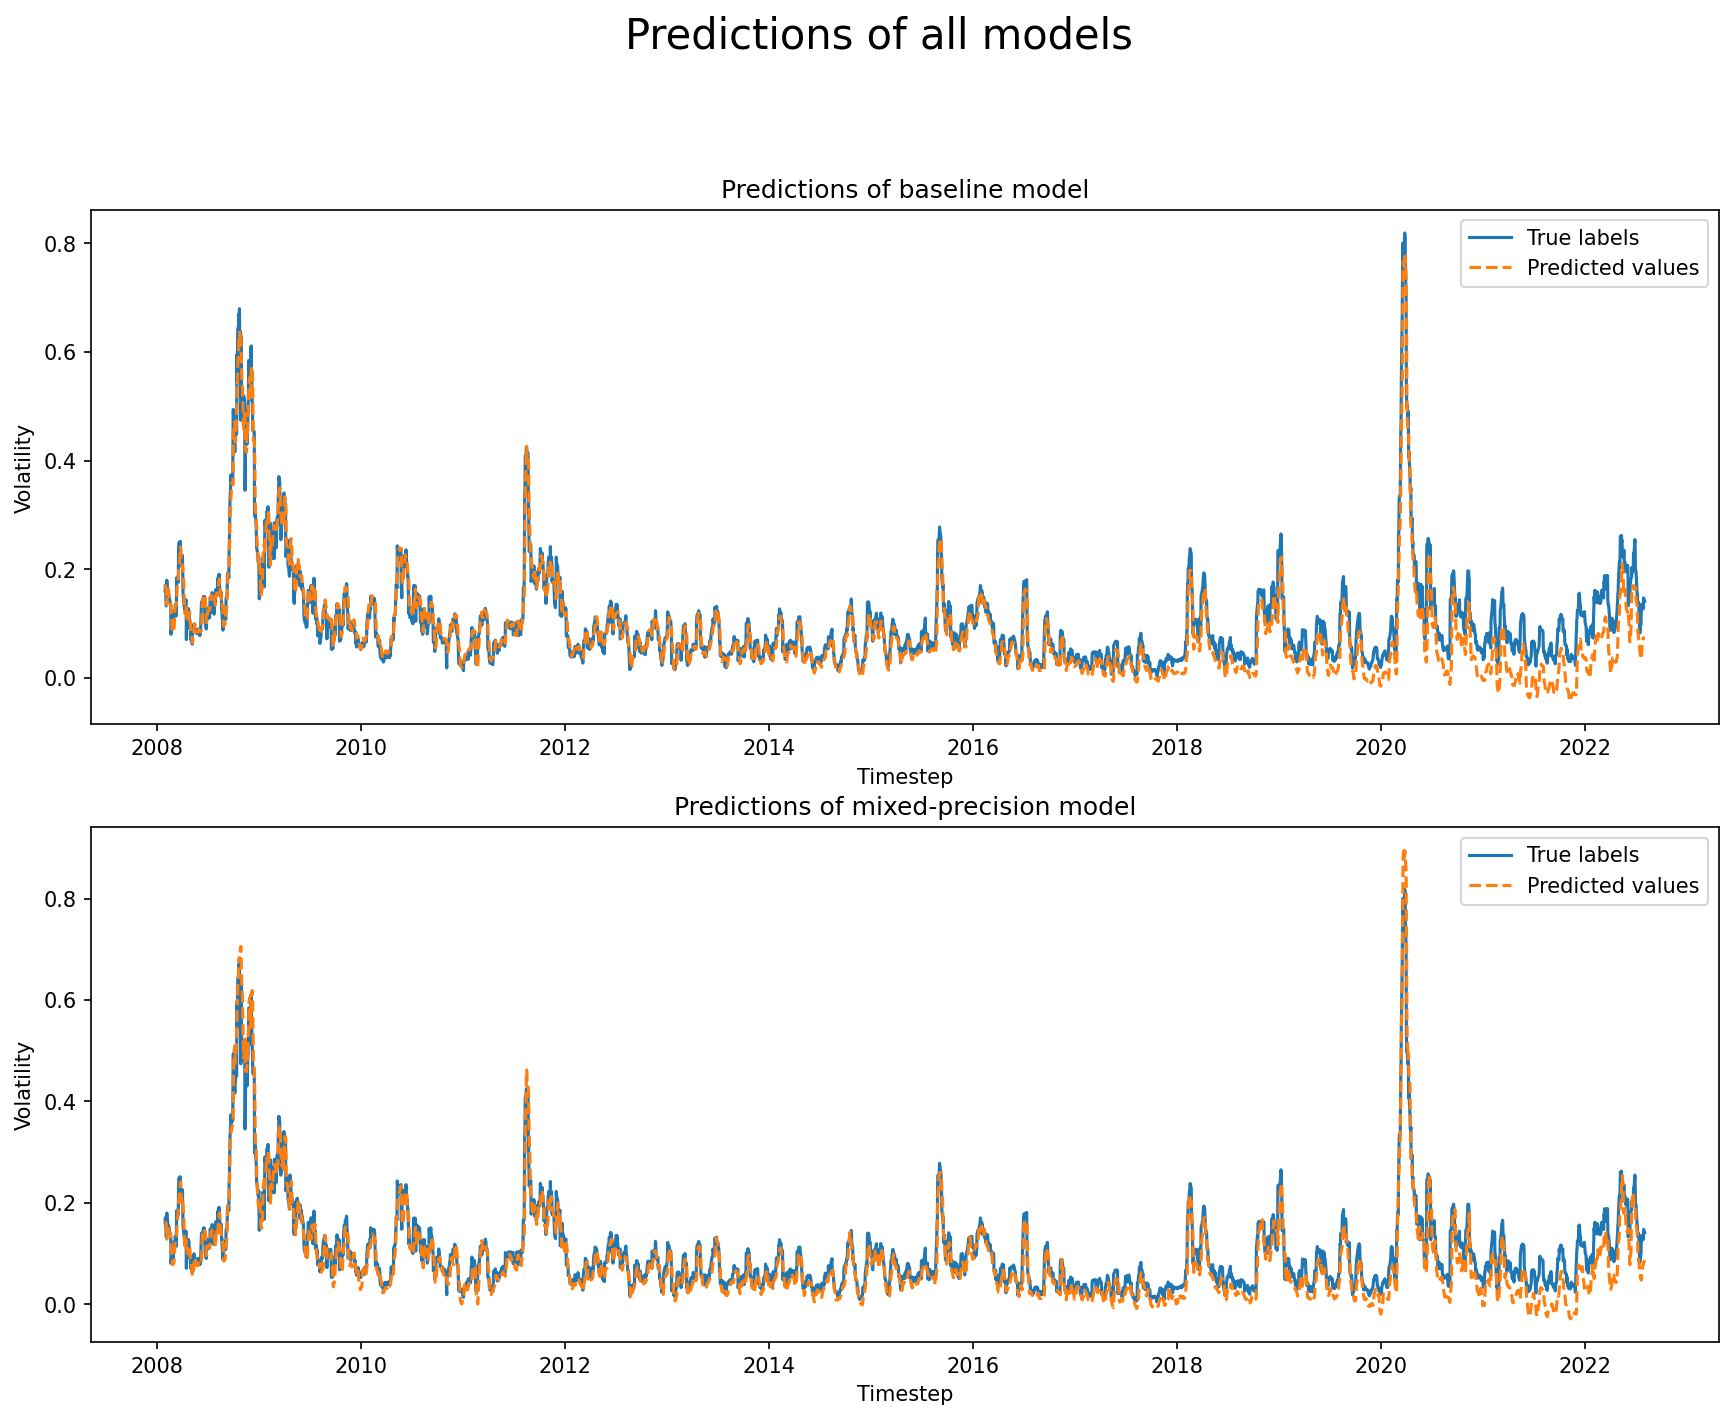

In [54]:
# plot the predictions of all models using their varying training processes
n_models = len(predictions.keys()) - 1

if n_models > 0:
    fig, ax = plt.subplots(n_models, 1, figsize=(14, 5 * n_models), dpi=150)
    fig.suptitle("Predictions of all models", fontsize=20, y=1.01)

    if n_models > 1:
        for i in range(n_models):
            key = list(predictions.keys())[i + 1]

            ax[i].plot(predictions['true'], label='True labels')
            ax[i].plot(predictions[key], linestyle='--', label='Predicted values')
            ax[i].legend(loc=0)
            ax[i].set_xlabel('Timestep')
            ax[i].set_ylabel('Volatility')
            ax[i].set_title(f'Predictions of {key} model')
    else:
        key = list(predictions.keys())[-1]

        ax.plot(predictions['true'], label='True labels')
        ax.plot(predictions[key], linestyle='--', label='Predicted values')
        ax.legend(loc=0)
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Volatility')
        ax.set_title(f'Predictions of {key} model')

    plt.show()
    fig.savefig(results_path + "all-predictions.png")

#### RMSE

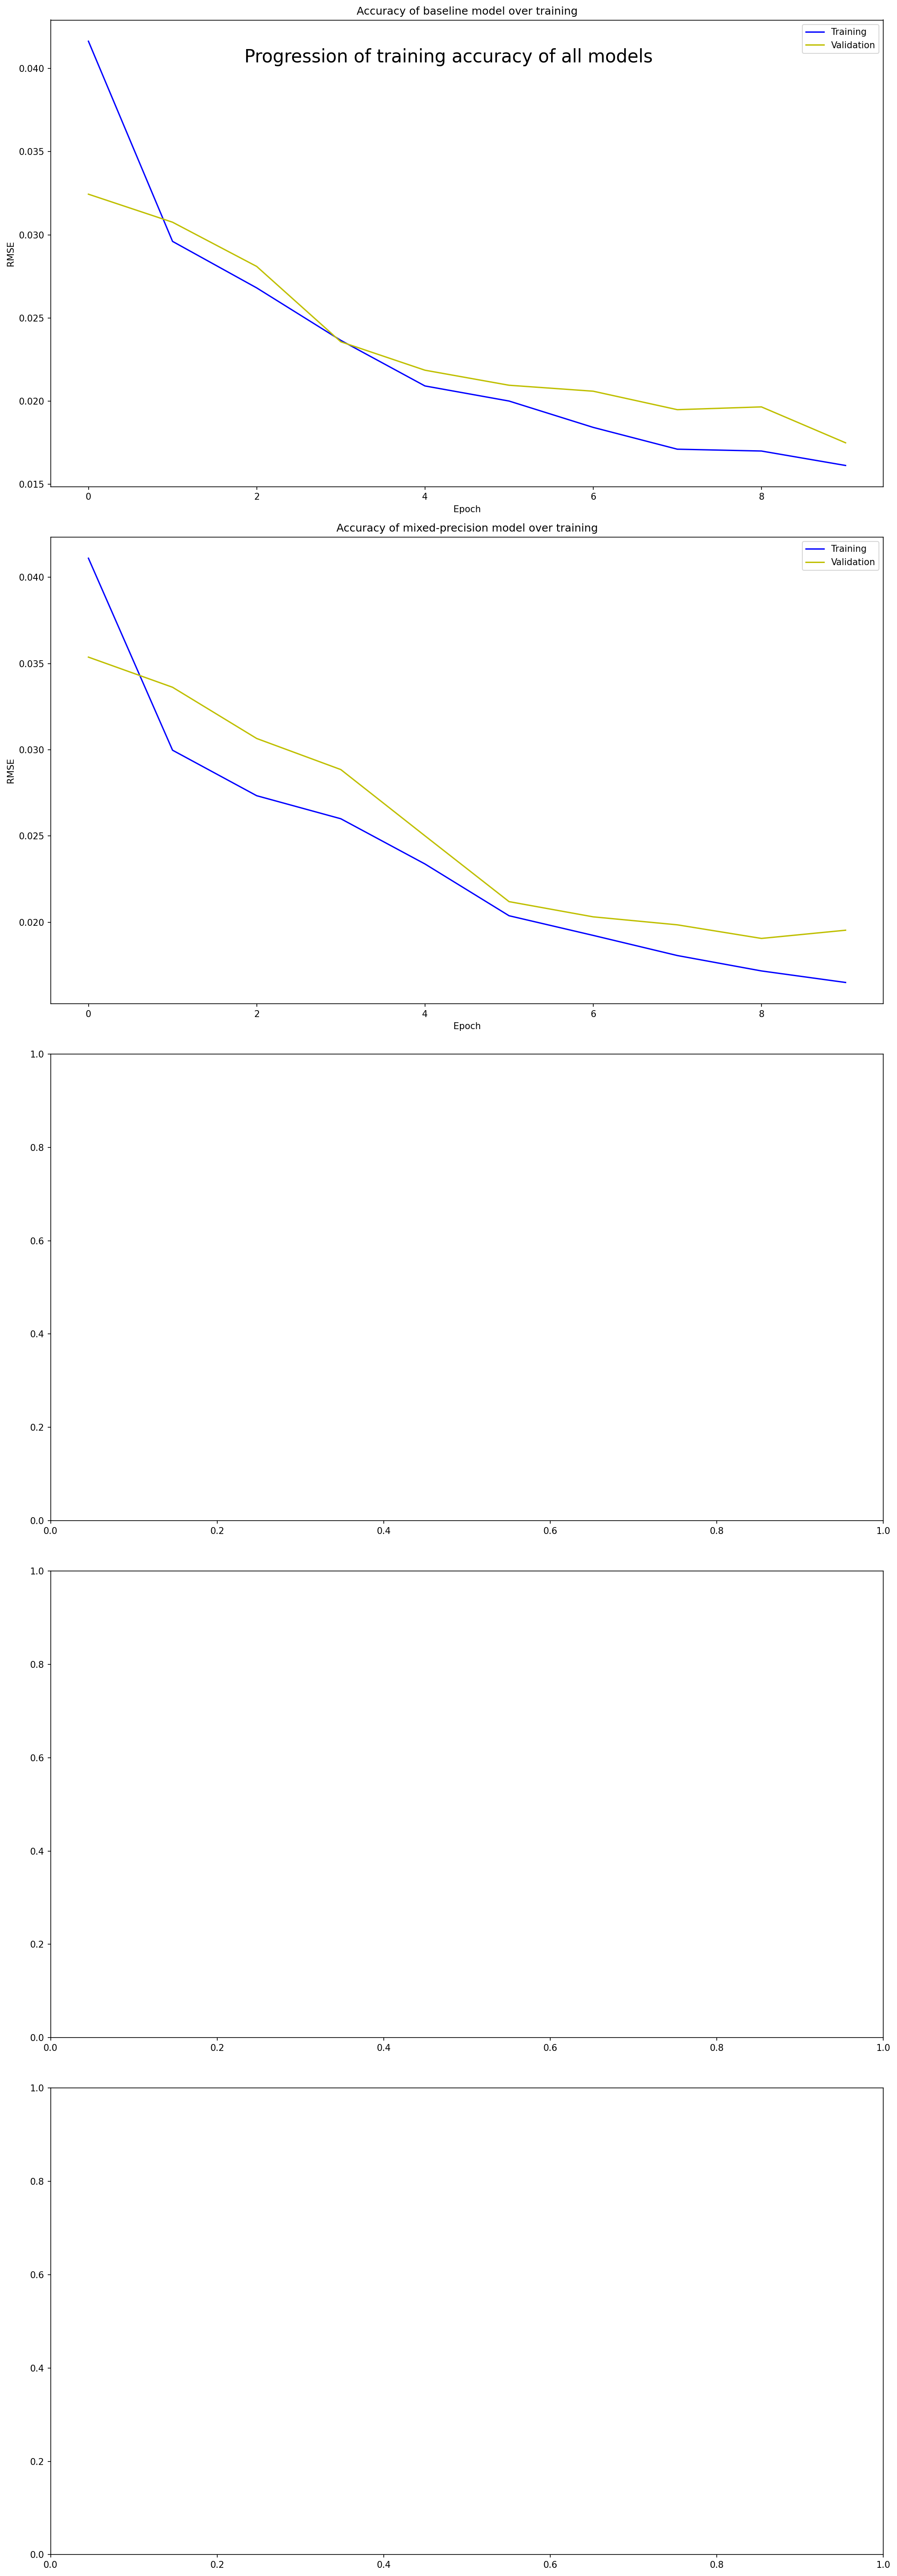

In [55]:
# plot accuracy of each training epoch for all models
n_models = len(analysis.keys())

if n_models > 0:
    fig, ax = plt.subplots(n_models, 1, figsize=(14, 8 * n_models), dpi=150)
    fig.suptitle("Progression of training accuracy of all models", fontsize=20)

    for i in range(n_models):
        key = list(analysis.keys())[i]
        acc_history = analysis[key]['history']
        if acc_history is not None:
            ax[i].plot(acc_history['root_mean_squared_error'], color='b', label="Training")
            ax[i].plot(acc_history['val_root_mean_squared_error'], color='y', label="Validation")
            ax[i].legend(loc=0)
            ax[i].set_xlabel('Epoch')
            ax[i].set_ylabel('RMSE')
            ax[i].set_title(f'Accuracy of {key} model over training')

    plt.tight_layout()
    plt.show()
    fig.savefig(results_path + "training-rmse.png")